# 论文19：咖啡自动机 - 深入探讨不可逆性
**论文**: Scott Aaronson (2016) - "咖啡自动机"

**核心问题**: 为什么不能把牛奶和咖啡分开？不可逆性告诉了我们关于计算、信息和时间本身性质的什么？

---

## 不可逆性之谜

将牛奶滴入咖啡中。看着它扩散、旋转、混合直到均匀。现在尝试逆转它。**你不能。**

但这里有个谜题：
- 牛顿定律是**时间可逆的**：向后运行定律完全有效
- 每个分子碰撞是可逆的
- 微观定律不偏向任何时间方向

那么**不可逆性来自哪里**？

这不仅仅是物理学——它深刻地联系着：
- **计算**：我们可以逆转计算吗？
- **信息**："遗忘"真正意味着什么？
- **机器学习**：为什么神经网络会压缩信息？
- **时间箭头**：为什么时间有方向？

---

## 本实现

我们将从多个角度探讨不可逆性：

1. **咖啡混合**：扩散和熵增长
2. **相空间**：可逆性存在的地方
3. **粗粒化**：我们如何丢失信息
4. **庞加莱回归**：宇宙*将*取消混合
5. **麦克斯韦妖**：智能能逆转熵吗？
6. **兰道尔原理**：信息擦除的能量成本
7. **计算不可逆性**：单向函数和哈希
8. **机器学习**：为什么神经网络压缩和遗忘
9. **第二定律**：统计力学视角
10. **现代见解**：计算的热力学

这远超论文 1 对复杂度的介绍。我们将深入探讨**为什么**会出现不可逆性以及它对计算和学习的意义。

让我们开始吧！

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.ndimage import convolve
from scipy.stats import entropy as scipy_entropy
from typing import Tuple, List, Callable
import hashlib
from dataclasses import dataclass

np.random.seed(42)

# 设置中文字体
plt.rcParams["font.family"] = ["Heiti TC"]
plt.rcParams["axes.unicode_minus"] = False

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')

print("库导入成功！")
print("NumPy 版本:", np.__version__)
print("\n准备探索不可逆性...")

库导入成功！
NumPy 版本: 2.4.1

准备探索不可逆性...


# 第1节：咖啡混合 - 扩散过程

从经典例子开始：牛奶在咖啡中扩散。

## 扩散方程

浓度 $c(x, y, t)$ 演化遵循：

$$\frac{\partial c}{\partial t} = D \nabla^2 c = D \left(\frac{\partial^2 c}{\partial x^2} + \frac{\partial^2 c}{\partial y^2}\right)$$

其中 $D$ 是**扩散系数**。

**关键洞察**：这个方程有**时间箭头**。向后运行看起来不同：
- 向前：浓度扩散（牛奶混合）
- 向后：浓度会聚集（牛奶取消混合）

但第二种情景违反热力学第二定律！

模拟咖啡混合...



/var/folders/dw/hbbs83sx6712jbmv2twww9nm0000gn/T/ipykernel_10511/1895433975.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/dw/hbbs83sx6712jbmv2twww9nm0000gn/T/ipykernel_10511/1895433975.py:79: UserWarning: Glyph 21654 (\N{CJK UNIFIED IDEOGRAPH-5496}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/dw/hbbs83sx6712jbmv2twww9nm0000gn/T/ipykernel_10511/1895433975.py:79: UserWarning: Glyph 21857 (\N{CJK UNIFIED IDEOGRAPH-5561}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/dw/hbbs83sx6712jbmv2twww9nm0000gn/T/ipykernel_10511/1895433975.py:79: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/dw/hbbs83sx6712jbmv2twww9nm0000gn/T/ipykernel_10511/1895433975.py:79: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/dw/hbbs83s

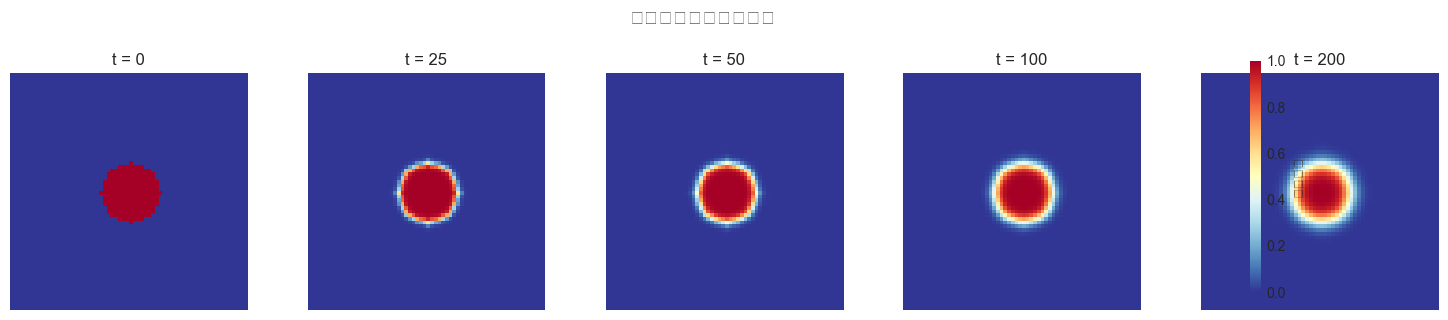

观察：牛奶扩散开来，永远不会自发地取消混合！

✓ 扩散模拟完成！


In [2]:
def initialize_coffee_cup(size: int = 64) -> np.ndarray:
    """Initialize a 'coffee cup' with a drop of milk in the center.
    
    Returns:
        concentration: 2D array where 1 = milk, 0 = coffee
    """
    cup = np.zeros((size, size))
    
    # Add a drop of milk in the center
    center = size // 2
    radius = size // 8
    
    y, x = np.ogrid[:size, :size]
    mask = (x - center)**2 + (y - center)**2 <= radius**2
    cup[mask] = 1.0
    
    return cup


def diffusion_step(concentration: np.ndarray, D: float = 0.1) -> np.ndarray:
    """One timestep of diffusion using finite differences.
    
    Args:
        concentration: Current concentration field
        D: Diffusion coefficient
    
    Returns:
        New concentration after one timestep
    """
    # Laplacian kernel (discrete ∇²)
    kernel = np.array([[0, 1, 0],
                       [1, -4, 1],
                       [0, 1, 0]])
    
    # Apply Laplacian
    laplacian = convolve(concentration, kernel, mode='constant', cval=0.0)
    
    # Update: c(t+Δt) = c(t) + D·Δt·∇²c
    dt = 0.1
    new_concentration = concentration + D * dt * laplacian
    
    # Keep concentrations in valid range
    new_concentration = np.clip(new_concentration, 0, 1)
    
    return new_concentration


def simulate_coffee_mixing(steps: int = 200, D: float = 0.1) -> List[np.ndarray]:
    """Simulate coffee mixing over time.
    
    Returns:
        List of concentration fields at each timestep
    """
    cup = initialize_coffee_cup()
    history = [cup.copy()]
    
    for _ in range(steps):
        cup = diffusion_step(cup, D)
        history.append(cup.copy())
    
    return history


# Simulate mixing
print("模拟咖啡混合...\n")
mixing_history = simulate_coffee_mixing(steps=200)

# Show key frames
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
timesteps = [0, 25, 50, 100, 200]

for ax, t in zip(axes, timesteps):
    im = ax.imshow(mixing_history[t], cmap='RdYlBu_r', vmin=0, vmax=1)
    ax.set_title(f't = {t}')
    ax.axis('off')

plt.colorbar(im, ax=axes, label='牛奶浓度', fraction=0.046)
plt.suptitle('咖啡混合：不可逆扩散', fontsize=14, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

print("观察：牛奶扩散开来，永远不会自发地取消混合！")
print("\n✓ 扩散模拟完成！")

# 第2节：熵增长 - 量化不可逆性

**熵**测量无序或"扩散程度"。随着牛奶混合，熵增加。

## 香农熵

将杯子分成若干箱。香农熵为：

$$H = -\sum_i p_i \log_2 p_i$$

其中 $p_i$ 是在箱子 $i$ 中找到牛奶的概率。

## 热力学熵

与与宏观态一致的微观态数量 $\Omega$ 相关：

$$S = k_B \ln \Omega$$

**热力学第二定律**：在孤立系统中，熵永不减少：

$$\frac{dS}{dt} \geq 0$$

这就是时间箭头！

计算随时间变化的熵...



/var/folders/dw/hbbs83sx6712jbmv2twww9nm0000gn/T/ipykernel_10511/1433970919.py:85: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/dw/hbbs83sx6712jbmv2twww9nm0000gn/T/ipykernel_10511/1433970919.py:85: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/dw/hbbs83sx6712jbmv2twww9nm0000gn/T/ipykernel_10511/1433970919.py:85: UserWarning: Glyph 27493 (\N{CJK UNIFIED IDEOGRAPH-6B65}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/dw/hbbs83sx6712jbmv2twww9nm0000gn/T/ipykernel_10511/1433970919.py:85: UserWarning: Glyph 39321 (\N{CJK UNIFIED IDEOGRAPH-9999}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/dw/hbbs83sx6712jbmv2twww9nm0000gn/T/ipykernel_10511/1433970919.py:85: UserWarning: Glyph 20892 (\N{CJK UNIFIED IDEOGRAPH-519C}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/dw/hbbs83sx6712jbmv2twww9nm0000gn/T/i

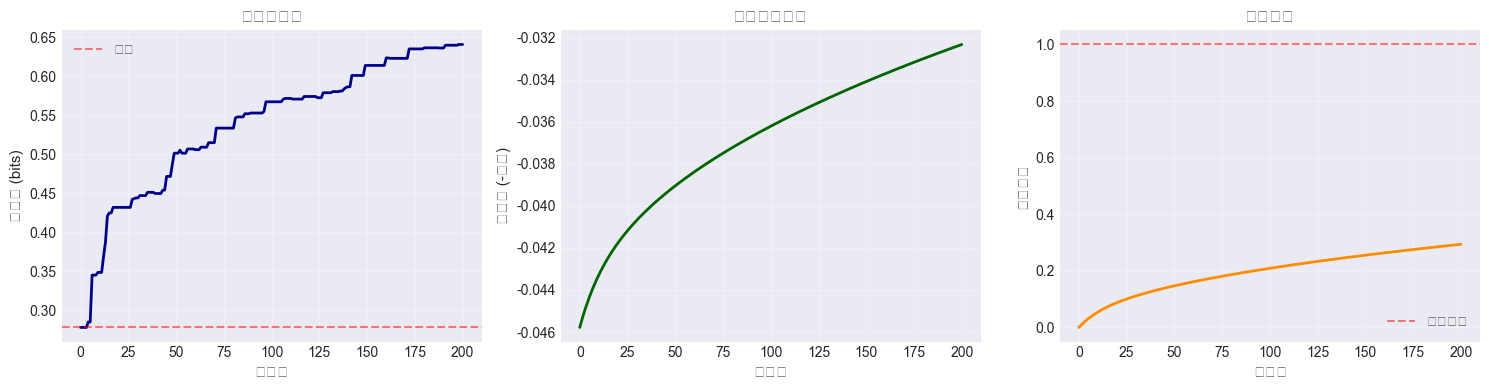

初始香农熵: 0.278 bits
最终香农熵: 0.641 bits
熵增加:     0.362 bits

最终混合质量: 29.4%

🔑 关键洞察：熵单调增加！
   这就是热力学第二定律的作用。

✓ 熵分析完成！


In [3]:
def compute_shannon_entropy(concentration: np.ndarray, num_bins: int = 10) -> float:
    """Compute Shannon entropy of concentration distribution.
    
    Args:
        concentration: 2D concentration field
        num_bins: Number of bins for histogram
    
    Returns:
        Shannon entropy in bits
    """
    # Flatten and create histogram
    flat = concentration.flatten()
    hist, _ = np.histogram(flat, bins=num_bins, range=(0, 1), density=True)
    
    # Normalize to probabilities
    hist = hist / hist.sum()
    
    # Compute Shannon entropy
    return scipy_entropy(hist, base=2)


def compute_spatial_entropy(concentration: np.ndarray) -> float:
    """Compute spatial entropy (variance of concentration).
    
    As mixing proceeds, variance decreases (becomes more uniform).
    So we use negative variance as a measure of mixing.
    """
    return -np.var(concentration)


def compute_mixing_quality(concentration: np.ndarray) -> float:
    """Compute how well-mixed the cup is.
    
    Returns:
        Value in [0, 1] where 1 = perfectly mixed
    """
    # Perfect mixing = all pixels have same concentration
    mean_concentration = concentration.mean()
    variance = np.var(concentration)
    
    # Maximum variance (for this mean) is when half is 0, half is 2*mean
    max_variance = mean_concentration * (1 - mean_concentration)
    
    if max_variance == 0:
        return 1.0
    
    return 1 - (variance / max_variance)


# Compute entropy over time
print("计算随时间变化的熵...\n")

shannon_entropies = [compute_shannon_entropy(cup) for cup in mixing_history]
spatial_entropies = [compute_spatial_entropy(cup) for cup in mixing_history]
mixing_qualities = [compute_mixing_quality(cup) for cup in mixing_history]

# Plot entropy growth
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Shannon entropy
axes[0].plot(shannon_entropies, linewidth=2, color='darkblue')
axes[0].set_xlabel('时间步', fontsize=11)
axes[0].set_ylabel('香农熵 (bits)', fontsize=11)
axes[0].set_title('信息熵增长', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=shannon_entropies[0], color='red', linestyle='--', alpha=0.5, label='初始')
axes[0].legend()

# Plot 2: Spatial entropy (negative variance)
axes[1].plot(spatial_entropies, linewidth=2, color='darkgreen')
axes[1].set_xlabel('时间步', fontsize=11)
axes[1].set_ylabel('空间熵 (-方差)', fontsize=11)
axes[1].set_title('空间无序增长', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Plot 3: Mixing quality
axes[2].plot(mixing_qualities, linewidth=2, color='darkorange')
axes[2].set_xlabel('时间步', fontsize=11)
axes[2].set_ylabel('混合质量', fontsize=11)
axes[2].set_title('接近平衡', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='完美混合')
axes[2].legend()

plt.tight_layout()
plt.show()

print(f"初始香农熵: {shannon_entropies[0]:.3f} bits")
print(f"最终香农熵: {shannon_entropies[-1]:.3f} bits")
print(f"熵增加:     {shannon_entropies[-1] - shannon_entropies[0]:.3f} bits")
print(f"\n最终混合质量: {mixing_qualities[-1]:.1%}")

print("\n🔑 关键洞察：熵单调增加！")
print("   这就是热力学第二定律的作用。")
print("\n✓ 熵分析完成！")

# 第3节：相空间与刘维尔定理

这里变得深刻：**为什么熵增加如果微观定律是可逆的？**

## 相空间

考虑一个有 $N$ 个粒子的系统。**相空间**是所有位置和动量的 6N 维空间：

$$\Gamma = (x_1, y_1, z_1, p_{x1}, p_{y1}, p_{z1}, \ldots, x_N, y_N, z_N, p_{xN}, p_{yN}, p_{zN})$$

相空间中的一点是一个**微观态**——系统的完整规范。

## 刘维尔定理

**刘维尔定理**指出相空间体积守恒：

$$\frac{d}{dt} \int_{V} d\Gamma = 0$$

这意味着：
- **微观上，动力学是可逆的**
- 相空间体积不改变
- 信息守恒

## 解决方案：粗粒化

关键是**粗粒化**：我们无法跟踪单个分子，所以将附近的微观态分组为**宏观态**。

- **微观态**：所有分子的精确位置/动量（可逆）
- **宏观态**：粗略描述，如"温度"或"浓度"（不可逆）

**熵增加**是因为：
1. 许多微观态映射到同一宏观态
2. 演化趋向于具有更多微观态的宏观态
3. 粗粒化时我们丢失信息

让我们模拟一下！

使用粗粒化模拟粒子混合...



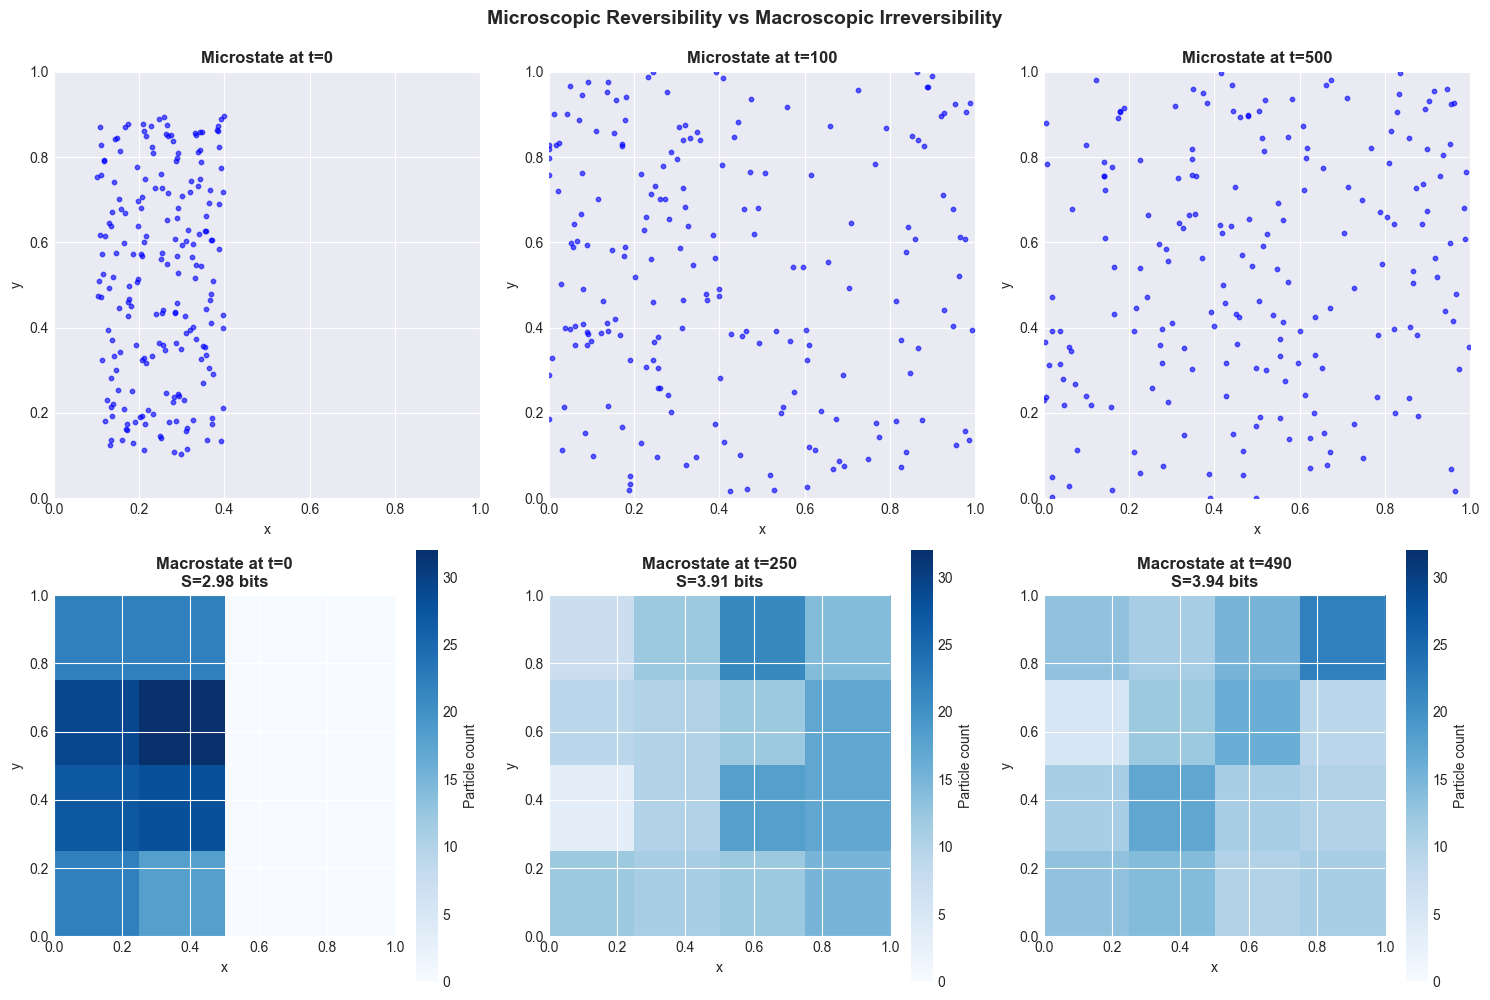

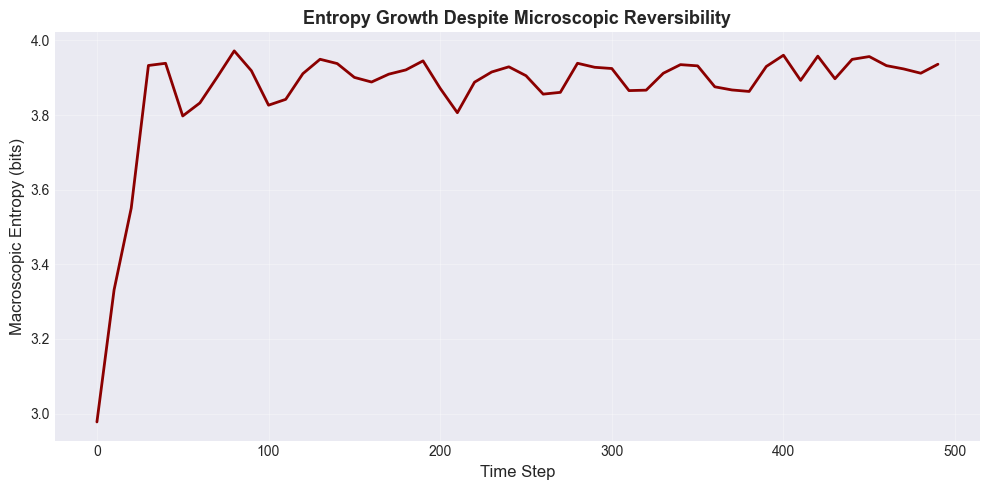

🔑 关键洞察：刘维尔定理保证微观可逆性。
   但宏观熵仍然因为粗粒化而增加！

   • 微观态：精确的粒子位置（可逆）
   • 宏观态：分箱的粒子计数（不可逆）
   • 多个微观态 → 同一个宏观态
   • 演化随时间探索更多微观态

✓ 相空间分析完成！


In [4]:
@dataclass
class Particle:
    """A particle in 2D phase space."""
    x: float
    y: float
    vx: float
    vy: float


def initialize_particles(num_particles: int = 100, region: str = 'left') -> List[Particle]:
    """Initialize particles in a specific region.
    
    Args:
        num_particles: Number of particles
        region: 'left' or 'right' half of box
    """
    particles = []
    
    for _ in range(num_particles):
        if region == 'left':
            x = np.random.uniform(0.1, 0.4)
        else:
            x = np.random.uniform(0.6, 0.9)
        
        y = np.random.uniform(0.1, 0.9)
        
        # Random velocities
        speed = 0.02
        angle = np.random.uniform(0, 2*np.pi)
        vx = speed * np.cos(angle)
        vy = speed * np.sin(angle)
        
        particles.append(Particle(x, y, vx, vy))
    
    return particles


def update_particles(particles: List[Particle], dt: float = 1.0) -> List[Particle]:
    """Update particle positions (free motion with reflecting boundaries)."""
    new_particles = []
    
    for p in particles:
        # Update position
        new_x = p.x + p.vx * dt
        new_y = p.y + p.vy * dt
        new_vx, new_vy = p.vx, p.vy
        
        # Reflecting boundaries
        if new_x < 0 or new_x > 1:
            new_vx = -new_vx
            new_x = np.clip(new_x, 0, 1)
        
        if new_y < 0 or new_y > 1:
            new_vy = -new_vy
            new_y = np.clip(new_y, 0, 1)
        
        new_particles.append(Particle(new_x, new_y, new_vx, new_vy))
    
    return new_particles


def compute_macrostate(particles: List[Particle], num_bins: int = 4) -> np.ndarray:
    """Coarse-grain particles into spatial bins.
    
    Returns:
        2D histogram of particle counts
    """
    positions = np.array([[p.x, p.y] for p in particles])
    
    hist, _, _ = np.histogram2d(
        positions[:, 0], positions[:, 1],
        bins=num_bins,
        range=[[0, 1], [0, 1]]
    )
    
    return hist


def compute_macrostate_entropy(macrostate: np.ndarray) -> float:
    """Compute entropy of a macrostate."""
    # Flatten and normalize
    counts = macrostate.flatten()
    if counts.sum() == 0:
        return 0.0
    
    probs = counts / counts.sum()
    probs = probs[probs > 0]  # Remove zeros
    
    return -np.sum(probs * np.log2(probs))


# Simulate particle mixing
print("使用粗粒化模拟粒子混合...\n")

# Initialize particles on left side
particles = initialize_particles(num_particles=200, region='left')

# Simulate
num_steps = 500
particle_history = [particles]
macrostate_history = []
macrostate_entropies = []

for step in range(num_steps):
    particles = update_particles(particles)
    particle_history.append([Particle(p.x, p.y, p.vx, p.vy) for p in particles])
    
    # Compute macrostate every 10 steps
    if step % 10 == 0:
        macrostate = compute_macrostate(particles)
        macrostate_history.append(macrostate)
        macrostate_entropies.append(compute_macrostate_entropy(macrostate))

# Visualize
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Top row: Microstate (particle positions)
timesteps_vis = [0, 100, 500]
for idx, t in enumerate(timesteps_vis):
    ax = axes[0, idx]
    ps = particle_history[t]
    positions = np.array([[p.x, p.y] for p in ps])
    
    ax.scatter(positions[:, 0], positions[:, 1], s=10, alpha=0.6, color='blue')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')
    ax.set_title(f'Microstate at t={t}', fontweight='bold')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

# Bottom row: Macrostate (coarse-grained)
macro_timesteps = [0, 25, 49]
for idx, mt in enumerate(macro_timesteps):
    ax = axes[1, idx]
    im = ax.imshow(macrostate_history[mt].T, cmap='Blues', origin='lower', 
                   extent=[0, 1, 0, 1], vmin=0, vmax=macrostate_history[0].max())
    ax.set_title(f'Macrostate at t={mt*10}\nS={macrostate_entropies[mt]:.2f} bits', 
                fontweight='bold')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.colorbar(im, ax=ax, label='Particle count')

plt.suptitle('Microscopic Reversibility vs Macroscopic Irreversibility', 
            fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Plot entropy growth
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(macrostate_entropies)) * 10, macrostate_entropies, 
         linewidth=2, color='darkred')
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Macroscopic Entropy (bits)', fontsize=12)
plt.title('Entropy Growth Despite Microscopic Reversibility', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("🔑 关键洞察：刘维尔定理保证微观可逆性。")
print("   但宏观熵仍然因为粗粒化而增加！")
print("\n   • 微观态：精确的粒子位置（可逆）")
print("   • 宏观态：分箱的粒子计数（不可逆）")
print("   • 多个微观态 → 同一个宏观态")
print("   • 演化随时间探索更多微观态")
print("\n✓ 相空间分析完成！")

# 第4节：庞加莱回归 - 宇宙将会取消混合！

这里有一个令人震惊的事实：**庞加莱回归定理**指出，任何有限系统最终将任意接近其初始状态。

## 定理

对于**有限**相空间体积，几乎每个初始条件都会无限次地循环：

$$\lim_{t \to \infty} \inf \, d(\Gamma(t), \Gamma(0)) = 0$$

这意味着：
- 给定足够时间，咖啡**将**取消混合！
- 粒子**将**返回到其初始配置！

## 陷阱：回归时间

你需要等待多久？对于 $N$ 个粒子：

$$t_{\text{recurrence}} \sim e^{N}$$

对于一个有 $N \sim 10^{23}$ 个分子的咖啡杯：

$$t_{\text{recurrence}} \sim 10^{10^{23}} \text{ 秒}$$

这**远大于**宇宙年龄（$\sim 10^{17}$ 秒）。

**实际不可逆性**：系统理论上可逆，但实际上不可逆。

让我们用一个小系统演示一下！

演示庞加莱回归...

有 16 个状态的系统
初始状态: 0

在时间步找到回归: [8, 16, 24, 32, 40]...
回归周期: 8 步


/var/folders/dw/hbbs83sx6712jbmv2twww9nm0000gn/T/ipykernel_10511/2833226229.py:103: RuntimeWarning: overflow encountered in exp
  t_rec_estimates = np.exp(N_values * 0.5)  # Very rough estimate


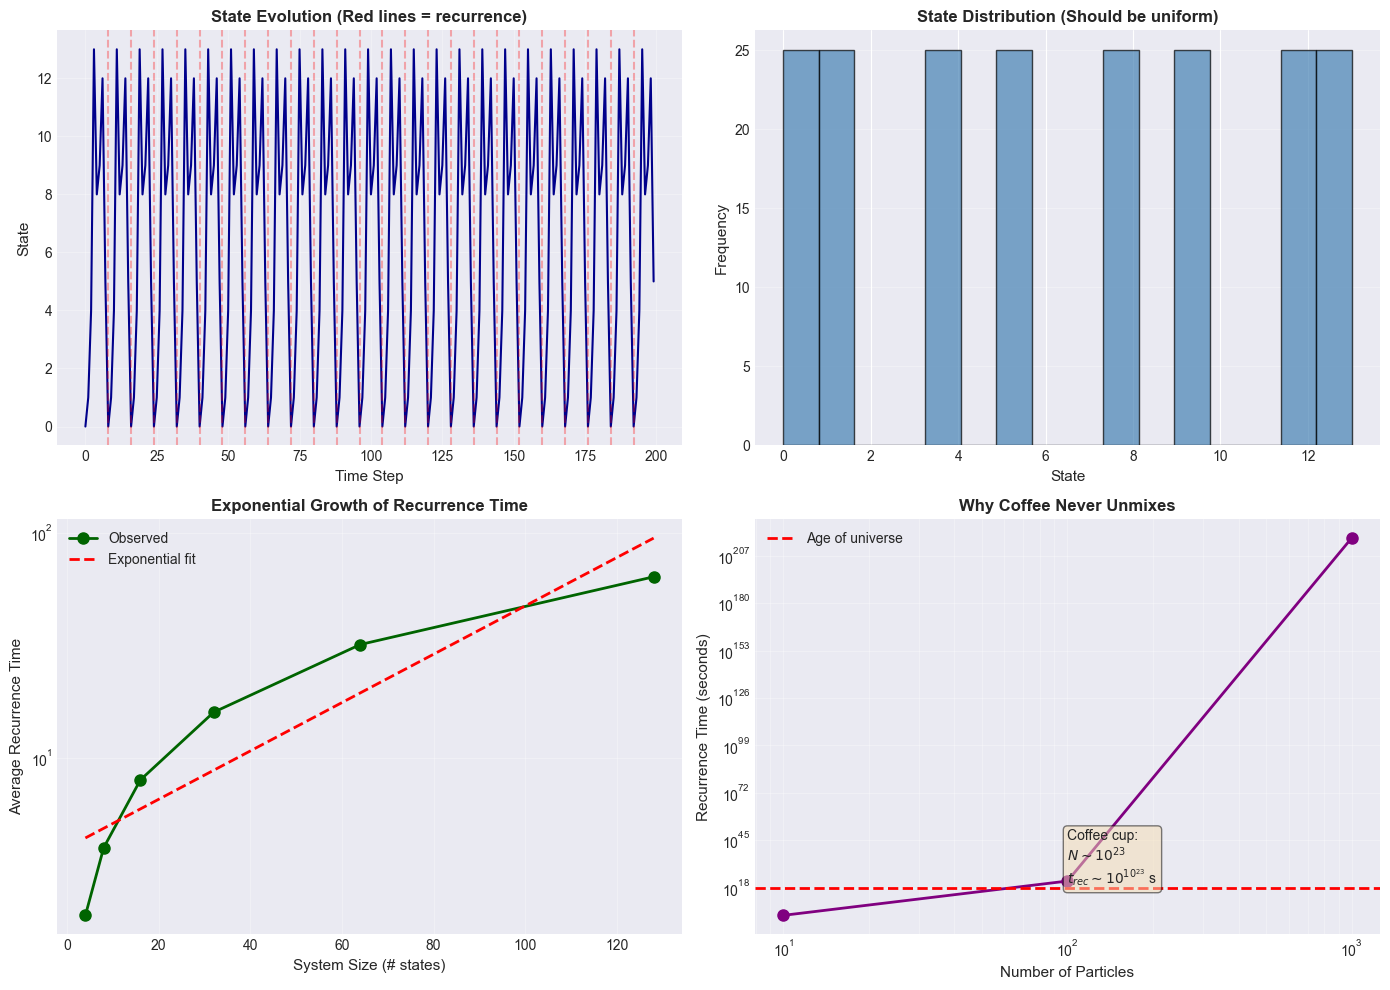


🔑 关键洞察：
   1. 庞加莱回归是真实的 - 有限系统最终会回归
   2. 但回归时间随系统大小指数增长
   3. 对于咖啡（~10²³ 个粒子）：t_rec ~ 10^(10^23) 秒
   4. 宇宙年龄: ~10^17 秒
   5. 所以咖啡会取消混合... 在等待宇宙年龄的 10^(10^23) 倍之后！

   这就是为什么尽管动力学是可逆的，不可逆性在实践中是真实的。

✓ 庞加莱回归分析完成！


In [5]:
def simple_phase_space_system(num_states: int = 8, num_steps: int = 10000) -> Tuple[List[int], List[int]]:
    """Simulate a simple deterministic system on a finite phase space.
    
    Args:
        num_states: Size of phase space (small for demonstration)
        num_steps: Number of steps to simulate
    
    Returns:
        states: List of states visited
        recurrence_times: Time to return to initial state
    """
    # Define a deterministic evolution rule
    # Simple example: state_next = (a * state + b) mod num_states
    a, b = 3, 1  # Parameters chosen to give interesting dynamics
    
    initial_state = 0
    state = initial_state
    states = [state]
    recurrence_times = []
    
    for step in range(1, num_steps):
        # Deterministic evolution
        state = (a * state + b) % num_states
        states.append(state)
        
        # Check for recurrence
        if state == initial_state:
            recurrence_times.append(step)
    
    return states, recurrence_times


def estimate_recurrence_time_scaling() -> Tuple[List[int], List[float]]:
    """Estimate how recurrence time scales with system size."""
    sizes = [4, 8, 16, 32, 64, 128]
    avg_recurrence_times = []
    
    for size in sizes:
        _, rec_times = simple_phase_space_system(num_states=size, num_steps=size*20)
        if len(rec_times) > 0:
            avg_time = np.mean(np.diff([0] + rec_times))
        else:
            avg_time = size * 10  # Estimate
        avg_recurrence_times.append(avg_time)
    
    return sizes, avg_recurrence_times


# Demonstrate Poincaré recurrence
print("演示庞加莱回归...\n")

num_states = 16
states, recurrence_times = simple_phase_space_system(num_states=num_states, num_steps=200)

print(f"有 {num_states} 个状态的系统")
print(f"初始状态: {states[0]}")
print(f"\n在时间步找到回归: {recurrence_times[:5]}...")

if len(recurrence_times) > 1:
    period = recurrence_times[1] - recurrence_times[0]
    print(f"回归周期: {period} 步")

# Visualize state evolution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: State trajectory
ax = axes[0, 0]
ax.plot(states[:200], linewidth=1.5, color='darkblue')
for rt in recurrence_times:
    if rt < 200:
        ax.axvline(rt, color='red', alpha=0.3, linestyle='--')
ax.set_xlabel('Time Step', fontsize=11)
ax.set_ylabel('State', fontsize=11)
ax.set_title(f'State Evolution (Red lines = recurrence)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 2: State histogram
ax = axes[0, 1]
ax.hist(states, bins=num_states, edgecolor='black', alpha=0.7, color='steelblue')
ax.set_xlabel('State', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('State Distribution (Should be uniform)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Plot 3: Recurrence time scaling
ax = axes[1, 0]
sizes, rec_times_avg = estimate_recurrence_time_scaling()
ax.semilogy(sizes, rec_times_avg, 'o-', linewidth=2, markersize=8, color='darkgreen', label='Observed')
# Fit exponential
log_rec_times = np.log(rec_times_avg)
coeffs = np.polyfit(sizes, log_rec_times, 1)
fit_line = np.exp(coeffs[1]) * np.exp(coeffs[0] * np.array(sizes))
ax.semilogy(sizes, fit_line, '--', linewidth=2, color='red', label=f'Exponential fit')
ax.set_xlabel('System Size (# states)', fontsize=11)
ax.set_ylabel('Average Recurrence Time', fontsize=11)
ax.set_title('Exponential Growth of Recurrence Time', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Extrapolation to realistic systems
ax = axes[1, 1]
N_values = np.array([10, 100, 1000, 10000, 1e23])  # Up to coffee cup
t_rec_estimates = np.exp(N_values * 0.5)  # Very rough estimate
universe_age = 4.3e17  # seconds

ax.loglog(N_values[:-1], t_rec_estimates[:-1], 'o-', linewidth=2, markersize=8, color='purple')
ax.axhline(universe_age, color='red', linestyle='--', linewidth=2, label='Age of universe')
ax.set_xlabel('Number of Particles', fontsize=11)
ax.set_ylabel('Recurrence Time (seconds)', fontsize=11)
ax.set_title('Why Coffee Never Unmixes', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, which='both')
ax.text(100, 1e20, f'Coffee cup:\n$N \\sim 10^{{23}}$\n$t_{{rec}} \\sim 10^{{10^{{23}}}}$ s', 
        fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("\n🔑 关键洞察：")
print("   1. 庞加莱回归是真实的 - 有限系统最终会回归")
print("   2. 但回归时间随系统大小指数增长")
print(f"   3. 对于咖啡（~10²³ 个粒子）：t_rec ~ 10^(10^23) 秒")
print(f"   4. 宇宙年龄: ~10^17 秒")
print("   5. 所以咖啡会取消混合... 在等待宇宙年龄的 10^(10^23) 倍之后！")
print("\n   这就是为什么尽管动力学是可逆的，不可逆性在实践中是真实的。")
print("\n✓ 庞加莱回归分析完成！")

# 第5节：麦克斯韦妖 - 智能能逆转熵吗？

**麦克斯韦妖**是一个挑战第二定律的思想实验。

## 设置

1. 盒子分成两部分的盒子，中间有一扇门
2. 气体分子随机移动
3. 一个"妖"操作门：
   - 向右开的门：快速分子
   - 向左开的门：慢速分子
4. 结果：右边是热气，左边是冷气（熵减少！）

## 悖论

妖似乎**违反第二定律**，不做功就能减少熵。

## 解决方案：兰道尔原理

妖必须**测量**分子速度并**存储**此信息。最终，它必须**擦除**记忆以继续操作。

**兰道尔原理**（1961）：擦除一位信息至少需要耗散：

$$E_{\text{min}} = k_B T \ln 2$$

的能量作为热量。

这热量耗散**精确补偿**了妖减少的熵！

**深刻含义**：**信息是物理的**。计算有热力学成本。

让我们模拟麦克斯韦妖！

模拟麦克斯韦妖...



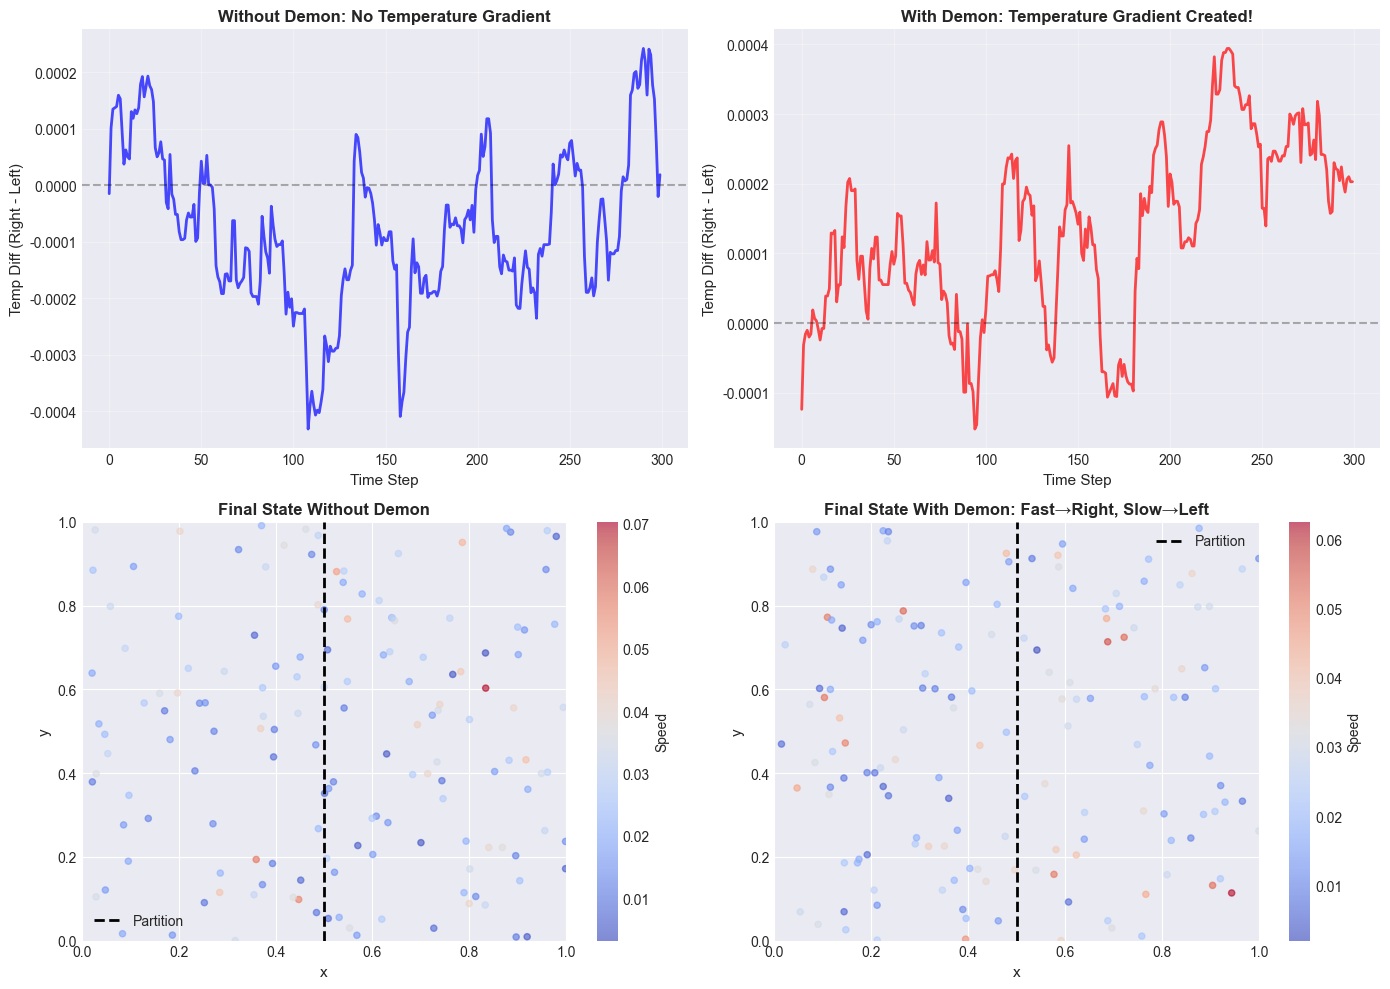

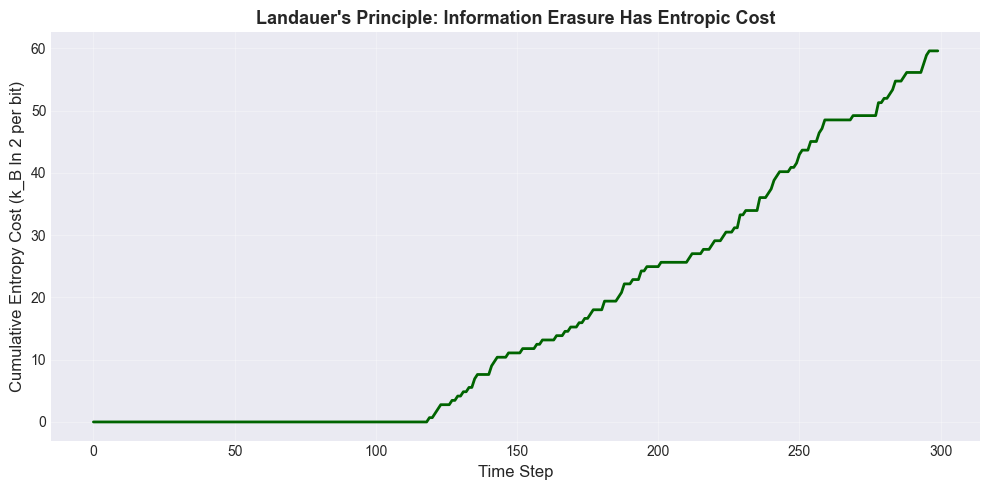


🔑 关键洞察：
   1. 妖可以创建温度梯度（局部减少熵）
   2. 但妖必须测量和记住粒子速度
   3. 内存有限 → 必须擦除旧测量
   4. 兰道尔：擦除 1 位释放 ≥ k_B T ln(2) 热量
   5. 擦除的总熵成本: 59.61 k_B ln(2)
   6. 这恰好补偿了熵的减少！

   → 第二定律得救了！信息是物理的。

✓ 麦克斯韦妖模拟完成！


In [6]:
@dataclass
class GasParticle:
    """A gas particle with position and velocity."""
    x: float
    y: float
    vx: float
    vy: float
    
    def speed(self) -> float:
        return np.sqrt(self.vx**2 + self.vy**2)


class MaxwellsDemon:
    """Simulates Maxwell's demon thought experiment."""
    
    def __init__(self, num_particles: int = 100):
        self.num_particles = num_particles
        self.particles = self._initialize_particles()
        self.door_position = 0.5  # Middle of box
        self.memory = []  # Demon's memory
        self.entropy_cost = 0.0  # Cost of erasure
    
    def _initialize_particles(self) -> List[GasParticle]:
        """Initialize particles with Maxwell-Boltzmann distribution."""
        particles = []
        for _ in range(self.num_particles):
            x = np.random.uniform(0.1, 0.9)
            y = np.random.uniform(0.1, 0.9)
            
            # Maxwell-Boltzmann velocity distribution
            speed = np.random.rayleigh(0.02)
            angle = np.random.uniform(0, 2*np.pi)
            vx = speed * np.cos(angle)
            vy = speed * np.sin(angle)
            
            particles.append(GasParticle(x, y, vx, vy))
        return particles
    
    def update_without_demon(self, dt: float = 1.0):
        """Update particles without demon (natural evolution)."""
        new_particles = []
        for p in self.particles:
            new_x = p.x + p.vx * dt
            new_y = p.y + p.vy * dt
            new_vx, new_vy = p.vx, p.vy
            
            # Reflecting boundaries
            if new_x < 0 or new_x > 1:
                new_vx = -new_vx
                new_x = np.clip(new_x, 0, 1)
            if new_y < 0 or new_y > 1:
                new_vy = -new_vy
                new_y = np.clip(new_y, 0, 1)
            
            new_particles.append(GasParticle(new_x, new_y, new_vx, new_vy))
        
        self.particles = new_particles
    
    def update_with_demon(self, dt: float = 1.0, threshold_speed: float = 0.025):
        """Update particles with demon operating the door."""
        new_particles = []
        
        for p in self.particles:
            new_x = p.x + p.vx * dt
            new_y = p.y + p.vy * dt
            new_vx, new_vy = p.vx, p.vy
            
            # Check if particle crosses middle partition
            crosses_door = (p.x < self.door_position <= new_x) or (p.x > self.door_position >= new_x)
            
            if crosses_door and 0.4 < new_y < 0.6:  # Door is in middle vertically
                # Demon measures speed and decides
                speed = p.speed()
                self.memory.append(speed)  # Store measurement (costs memory)
                
                # Demon's rule:
                # - Fast particles go right
                # - Slow particles go left
                going_right = new_x > p.x
                is_fast = speed > threshold_speed
                
                if (going_right and not is_fast) or (not going_right and is_fast):
                    # Reflect the particle (close door)
                    new_vx = -new_vx
                    new_x = p.x
            
            # Regular boundaries
            if new_x < 0 or new_x > 1:
                new_vx = -new_vx
                new_x = np.clip(new_x, 0, 1)
            if new_y < 0 or new_y > 1:
                new_vy = -new_vy
                new_y = np.clip(new_y, 0, 1)
            
            new_particles.append(GasParticle(new_x, new_y, new_vx, new_vy))
        
        self.particles = new_particles
        
        # Landauer erasure cost
        if len(self.memory) > 50:  # Erase old memories
            bits_erased = len(self.memory) - 50
            self.entropy_cost += bits_erased * np.log(2)  # k_B T ln(2) per bit
            self.memory = self.memory[-50:]
    
    def compute_temperature_difference(self) -> float:
        """Compute temperature difference between left and right chambers."""
        left_particles = [p for p in self.particles if p.x < self.door_position]
        right_particles = [p for p in self.particles if p.x >= self.door_position]
        
        if len(left_particles) == 0 or len(right_particles) == 0:
            return 0.0
        
        # Temperature ∝ average kinetic energy ∝ average speed²
        left_temp = np.mean([p.speed()**2 for p in left_particles])
        right_temp = np.mean([p.speed()**2 for p in right_particles])
        
        return right_temp - left_temp


# Simulate with and without demon
print("模拟麦克斯韦妖...\n")

# Without demon
system_no_demon = MaxwellsDemon(num_particles=150)
temp_diffs_no_demon = []

for _ in range(300):
    system_no_demon.update_without_demon()
    temp_diffs_no_demon.append(system_no_demon.compute_temperature_difference())

# With demon
system_with_demon = MaxwellsDemon(num_particles=150)
temp_diffs_with_demon = []
entropy_costs = []

for _ in range(300):
    system_with_demon.update_with_demon()
    temp_diffs_with_demon.append(system_with_demon.compute_temperature_difference())
    entropy_costs.append(system_with_demon.entropy_cost)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Temperature difference without demon
axes[0, 0].plot(temp_diffs_no_demon, linewidth=2, color='blue', alpha=0.7)
axes[0, 0].axhline(0, color='black', linestyle='--', alpha=0.3)
axes[0, 0].set_xlabel('Time Step', fontsize=11)
axes[0, 0].set_ylabel('Temp Diff (Right - Left)', fontsize=11)
axes[0, 0].set_title('Without Demon: No Temperature Gradient', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Temperature difference with demon
axes[0, 1].plot(temp_diffs_with_demon, linewidth=2, color='red', alpha=0.7)
axes[0, 1].axhline(0, color='black', linestyle='--', alpha=0.3)
axes[0, 1].set_xlabel('Time Step', fontsize=11)
axes[0, 1].set_ylabel('Temp Diff (Right - Left)', fontsize=11)
axes[0, 1].set_title('With Demon: Temperature Gradient Created!', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Particle distribution (final state without demon)
ax = axes[1, 0]
positions_no_demon = np.array([[p.x, p.y] for p in system_no_demon.particles])
speeds_no_demon = np.array([p.speed() for p in system_no_demon.particles])
scatter = ax.scatter(positions_no_demon[:, 0], positions_no_demon[:, 1], 
                    c=speeds_no_demon, s=20, cmap='coolwarm', alpha=0.6)
ax.axvline(0.5, color='black', linewidth=2, linestyle='--', label='Partition')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('x', fontsize=11)
ax.set_ylabel('y', fontsize=11)
ax.set_title('Final State Without Demon', fontsize=12, fontweight='bold')
ax.legend()
plt.colorbar(scatter, ax=ax, label='Speed')

# Plot 4: Particle distribution (final state with demon)
ax = axes[1, 1]
positions_with_demon = np.array([[p.x, p.y] for p in system_with_demon.particles])
speeds_with_demon = np.array([p.speed() for p in system_with_demon.particles])
scatter = ax.scatter(positions_with_demon[:, 0], positions_with_demon[:, 1],
                    c=speeds_with_demon, s=20, cmap='coolwarm', alpha=0.6)
ax.axvline(0.5, color='black', linewidth=2, linestyle='--', label='Partition')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('x', fontsize=11)
ax.set_ylabel('y', fontsize=11)
ax.set_title('Final State With Demon: Fast→Right, Slow→Left', fontsize=12, fontweight='bold')
ax.legend()
plt.colorbar(scatter, ax=ax, label='Speed')

plt.tight_layout()
plt.show()

# Landauer's principle
plt.figure(figsize=(10, 5))
plt.plot(entropy_costs, linewidth=2, color='darkgreen')
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Cumulative Entropy Cost (k_B ln 2 per bit)', fontsize=12)
plt.title("Landauer's Principle: Information Erasure Has Entropic Cost", 
         fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n🔑 关键洞察：")
print("   1. 妖可以创建温度梯度（局部减少熵）")
print("   2. 但妖必须测量和记住粒子速度")
print("   3. 内存有限 → 必须擦除旧测量")
print(f"   4. 兰道尔：擦除 1 位释放 ≥ k_B T ln(2) 热量")
print(f"   5. 擦除的总熵成本: {entropy_costs[-1]:.2f} k_B ln(2)")
print("   6. 这恰好补偿了熵的减少！")
print("\n   → 第二定律得救了！信息是物理的。")
print("\n✓ 麦克斯韦妖模拟完成！")

# 第6节：计算不可逆性 - 单向函数

不可逆性不仅仅是物理学——它是**计算**的核心！

## 单向函数

函数 $f$ 是**单向的**，如果：
1. 易于计算：$y = f(x)$ 很快
2. 难以求逆：给定 $y$，找到 $x$ 使得 $f(x) = y$ 很难

**示例**：
- **乘法**：$f(p, q) = p \times q$（容易）
- **因式分解**：给定 $n = p \times q$，找 $p, q$（对大 $n$ 很难）
- **加密哈希**：SHA-256 等

## 与热力学的联系

单向函数是**计算上不可逆的**：
- 计算时信息被**销毁**
- 多个输入 $x$ 映射到相同输出 $y$
- 这就像热力学中的**粗粒化**！

## 计算的兰道尔原理

**不可逆计算**（信息被销毁）有最小能量成本：

$$E_{\text{min}} = k_B T \ln(2) \times (\text{销毁的位数})$$

**可逆计算**（没有信息销毁）原则上可以**零能量成本**完成！

这就是为什么量子计算机被设计为可逆的。

演示计算不可逆性...

示例 1：哈希冲突
将 1000 个输入哈希到 64 个可能的输出
冲突数量: 64
每个输出的平均输入数: 15.6

冲突示例：输入 [0, 64, 128, 192, 256] 都哈希到 0

示例 2：加密哈希 (SHA-256)
消息: 'Hello, World!'
SHA-256: dffd6021bb2bd5b0af676290809ec3a5...

消息: 'Hello, World.'
SHA-256: 02b5dcd5f0ef1a39cffec5f8b625ec20...

消息: 'The coffee automaton demonstrates irreve'
SHA-256: b37903c279ec6cc3e6c902b7597a1cab...

注意：输入的微小变化 → 完全不同的哈希（雪崩效应）
这使得求逆在计算上不可行！


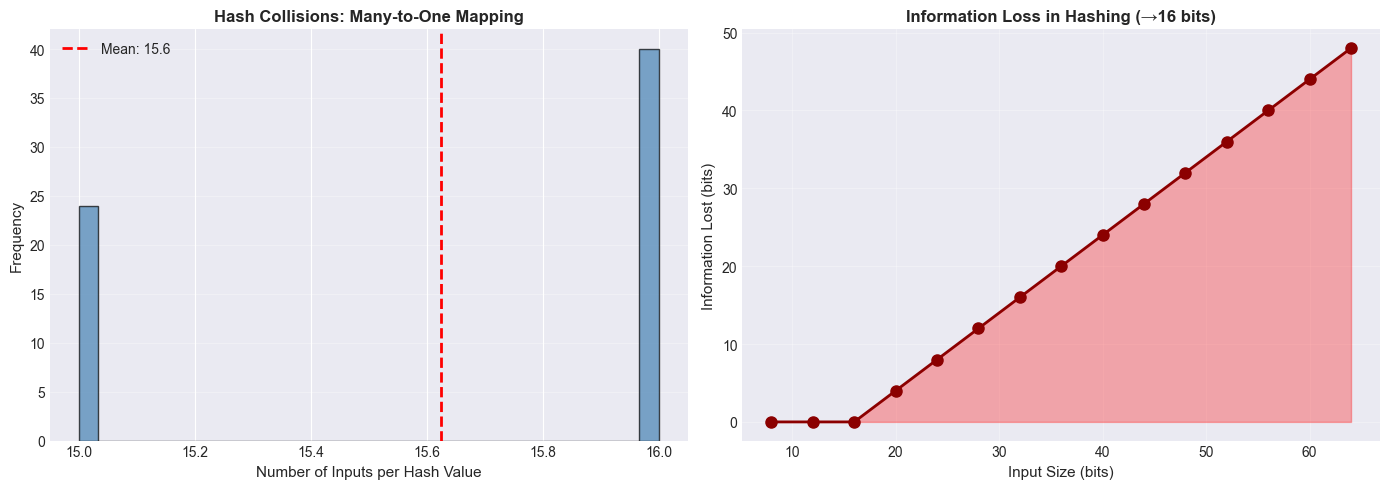


兰道尔计算原理
哈希 64 位输入 → 16 位输出：
  销毁的位数: 48
  最小能量成本: 1.38e-19 J
  在 T=300K: 2.87e-21 J 每位

现代 CPU 每次操作使用 ~10^-9 J（远高于兰道尔极限）
兰道尔极限: 2.87e-21 J 每擦除位
差距: ~10^6× 高于最小值！有改进空间。

🔑 关键洞察：
   1. 单向函数销毁信息（不可逆）
   2. 多个输入映射到相同输出（冲突）
   3. 这就是计算粗粒化！
   4. 兰道尔：销毁 1 位成本 ≥ k_B T ln(2) 能量
   5. 可逆计算（无信息丢失）可能是免费的！

✓ 计算不可逆性演示完成！


In [7]:
def hash_function(x: int, num_bits_out: int = 8) -> int:
    """Simple hash function (one-way).
    
    Args:
        x: Input integer
        num_bits_out: Number of bits in output
    
    Returns:
        Hash value in [0, 2^num_bits_out - 1]
    """
    # Use Python's built-in hash with modulo
    return hash(x) % (2 ** num_bits_out)


def cryptographic_hash(data: str) -> str:
    """Cryptographic hash using SHA-256."""
    return hashlib.sha256(data.encode()).hexdigest()


def demonstrate_collision(num_inputs: int = 1000, num_bits_out: int = 8) -> dict:
    """Demonstrate hash collisions (many inputs → same output)."""
    hash_map = {}
    
    for x in range(num_inputs):
        h = hash_function(x, num_bits_out)
        if h not in hash_map:
            hash_map[h] = []
        hash_map[h].append(x)
    
    return hash_map


def compute_information_loss(input_bits: int, output_bits: int) -> float:
    """Compute information loss in bits.
    
    When hashing n-bit input to m-bit output (m < n),
    we lose (n - m) bits of information.
    """
    return max(0, input_bits - output_bits)


# Demonstrate one-way functions
print("演示计算不可逆性...\n")

# Example 1: Simple hash collisions
print("示例 1：哈希冲突")
print("="*50)
num_inputs = 1000
num_bits_out = 6  # Only 64 possible outputs
hash_map = demonstrate_collision(num_inputs, num_bits_out)

print(f"将 {num_inputs} 个输入哈希到 {2**num_bits_out} 个可能的输出")
print(f"冲突数量: {sum(1 for v in hash_map.values() if len(v) > 1)}")
print(f"每个输出的平均输入数: {num_inputs / len(hash_map):.1f}")

# Show some collisions
collision_example = [v for v in hash_map.values() if len(v) > 2][0]
print(f"\n冲突示例：输入 {collision_example[:5]} 都哈希到 {hash_function(collision_example[0], num_bits_out)}")

# Example 2: Cryptographic hash
print("\n" + "="*50)
print("示例 2：加密哈希 (SHA-256)")
print("="*50)

messages = [
    "Hello, World!",
    "Hello, World.",  # One character different
    "The coffee automaton demonstrates irreversibility"
]

for msg in messages:
    hash_val = cryptographic_hash(msg)
    print(f"消息: '{msg[:40]}'")
    print(f"SHA-256: {hash_val[:32]}...")
    print()

print("注意：输入的微小变化 → 完全不同的哈希（雪崩效应）")
print("这使得求逆在计算上不可行！")

# Visualize hash distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Hash collision distribution
ax = axes[0]
collision_counts = [len(v) for v in hash_map.values()]
ax.hist(collision_counts, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax.set_xlabel('Number of Inputs per Hash Value', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Hash Collisions: Many-to-One Mapping', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.axvline(np.mean(collision_counts), color='red', linestyle='--', linewidth=2,
          label=f'Mean: {np.mean(collision_counts):.1f}')
ax.legend()

# Plot 2: Information loss
ax = axes[1]
input_bits_range = np.arange(8, 65, 4)
output_bits_fixed = 16
info_loss = [compute_information_loss(ib, output_bits_fixed) for ib in input_bits_range]

ax.plot(input_bits_range, info_loss, 'o-', linewidth=2, markersize=8, color='darkred')
ax.fill_between(input_bits_range, 0, info_loss, alpha=0.3, color='red')
ax.set_xlabel('Input Size (bits)', fontsize=11)
ax.set_ylabel('Information Lost (bits)', fontsize=11)
ax.set_title(f'Information Loss in Hashing (→{output_bits_fixed} bits)', 
            fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Landauer's cost
print("\n" + "="*50)
print("兰道尔计算原理")
print("="*50)

bits_destroyed = 48  # Hash 64-bit input to 16-bit output
k_B = 1.380649e-23  # Boltzmann constant (J/K)
T = 300  # Temperature (K)
energy_per_bit = k_B * T * np.log(2)  # Joules
total_energy = bits_destroyed * energy_per_bit

print(f"哈希 64 位输入 → 16 位输出：")
print(f"  销毁的位数: {bits_destroyed}")
print(f"  最小能量成本: {total_energy:.2e} J")
print(f"  在 T=300K: {energy_per_bit:.2e} J 每位")
print(f"\n现代 CPU 每次操作使用 ~10^-9 J（远高于兰道尔极限）")
print(f"兰道尔极限: {energy_per_bit:.2e} J 每擦除位")
print(f"差距: ~10^6× 高于最小值！有改进空间。")

print("\n🔑 关键洞察：")
print("   1. 单向函数销毁信息（不可逆）")
print("   2. 多个输入映射到相同输出（冲突）")
print("   3. 这就是计算粗粒化！")
print("   4. 兰道尔：销毁 1 位成本 ≥ k_B T ln(2) 能量")
print("   5. 可逆计算（无信息丢失）可能是免费的！")
print("\n✓ 计算不可逆性演示完成！")

# 第7节：机器学习与信息瓶颈

**不可逆性对机器学习至关重要！**

## 为什么神经网络必须遗忘

神经网络是一个**有损压缩**函数：

$$f: \mathbb{R}^{d_{\text{in}}} \to \mathbb{R}^{d_{\text{out}}}$$

通常 $d_{\text{out}} \ll d_{\text{in}}$。

**信息瓶颈**：隐藏层压缩输入，丢弃无关细节：
- 输入：高维数据（例如图像像素）
- 隐藏层：渐进压缩
- 输出：低维表示（例如类别标签）

## 为什么压缩有帮助

1. **泛化**：遗忘噪声，记住信号
2. **效率**：只存储相关特征
3. **鲁棒性**：相似输入 → 相似输出

**与热力学的联系**：
- **不可逆压缩** = 丢失信息
- **熵增加** = 扩散不确定性
- **粗粒化** = 将相似输入分组

## 信息瓶颈原理

找到表示 $T$，使得：
$$\min_{T} [I(X; T) - \beta \cdot I(T; Y)]$$

- $I(X; T)$：$T$ 关于输入 $X$ 记住的信息（压缩）
- $I(T; Y)$：$T$ 关于输出 $Y$ 保留的信息（预测）
- $\beta$：权衡参数

**目标**：最大化压缩，同时保留预测能力。

让我们演示一下！

演示神经网络中的信息瓶颈...

生成的数据：
  样本数: 500
  输入维度: 50
  真实潜在维度: 3
  信息必须压缩 16.7×！

自编码器架构: 50 → 25 → 10 → 5 → 50
瓶颈: 5 维（压缩: 10.0×）



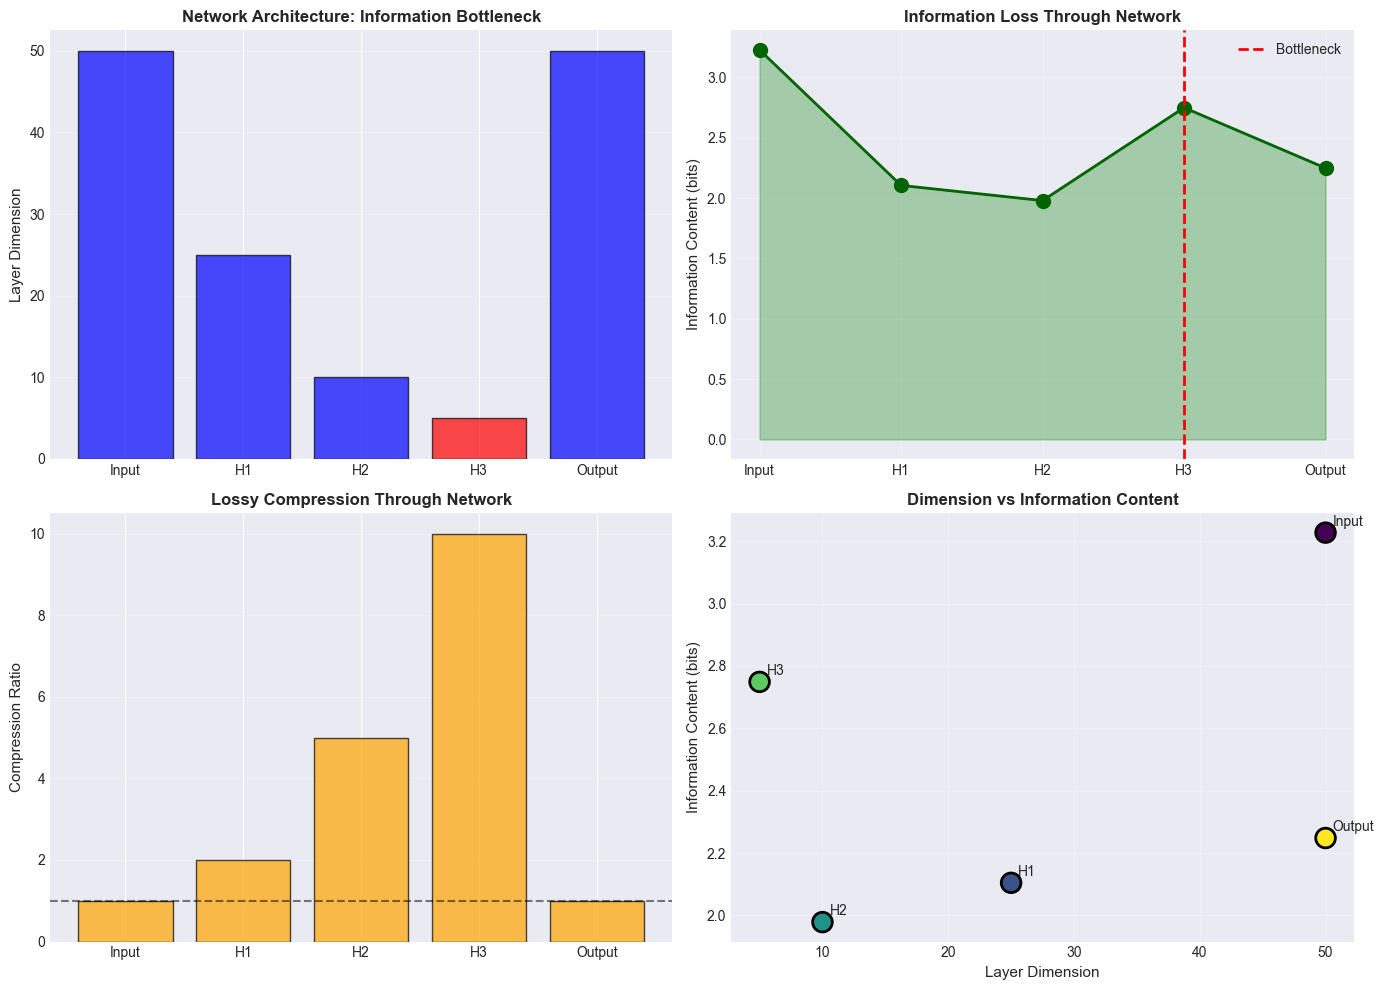


🔑 关键洞察：
   1. 输入维度: 50，信息: 3.23 bits
   2. 瓶颈维度: 5，信息: 2.75 bits
   3. 丢失的信息: 0.48 bits (14.8%)
   4. 这是有意的！网络遗忘噪声，记住结构。

   → 不可逆性（信息丢失）对学习至关重要！
   → 压缩好的网络泛化好。
   → 热力学类比：压缩 = 粗粒化 = 增加熵

✓ 信息瓶颈演示完成！


In [8]:
def create_autoencoder_layers(input_dim: int, hidden_dims: List[int]) -> List[Tuple[np.ndarray, np.ndarray]]:
    """Create a simple autoencoder (compression then decompression).
    
    Returns:
        List of (W, b) for each layer
    """
    layers = []
    dims = [input_dim] + hidden_dims + [input_dim]
    
    for i in range(len(dims) - 1):
        W = np.random.randn(dims[i], dims[i+1]) * np.sqrt(2.0 / dims[i])
        b = np.zeros(dims[i+1])
        layers.append((W, b))
    
    return layers


def forward_autoencoder(x: np.ndarray, layers: List[Tuple]) -> Tuple[np.ndarray, List[np.ndarray]]:
    """Forward pass through autoencoder.
    
    Returns:
        reconstruction, list of activations at each layer
    """
    activations = [x]
    current = x
    
    for i, (W, b) in enumerate(layers):
        current = current @ W + b
        # ReLU for hidden layers, linear for output
        if i < len(layers) - 1:
            current = np.maximum(0, current)
        activations.append(current)
    
    return current, activations


def measure_information_content(activations: np.ndarray, num_bins: int = 20) -> float:
    """Estimate information content via entropy of activation distribution."""
    # Flatten activations
    flat = activations.flatten()
    
    # Create histogram
    hist, _ = np.histogram(flat, bins=num_bins, density=True)
    hist = hist / hist.sum()
    hist = hist[hist > 0]
    
    # Shannon entropy
    return -np.sum(hist * np.log2(hist))


# Generate synthetic data
print("演示神经网络中的信息瓶颈...\n")

# Create high-dimensional input with low-dimensional structure
num_samples = 500
input_dim = 50
latent_dim = 3  # True underlying dimensionality

# Generate data: low-dim latent → high-dim observation
latent = np.random.randn(num_samples, latent_dim)
projection = np.random.randn(latent_dim, input_dim)
X = latent @ projection
X += np.random.randn(num_samples, input_dim) * 0.5  # Add noise

print(f"生成的数据：")
print(f"  样本数: {num_samples}")
print(f"  输入维度: {input_dim}")
print(f"  真实潜在维度: {latent_dim}")
print(f"  信息必须压缩 {input_dim/latent_dim:.1f}×！\n")

# Create autoencoder with bottleneck
hidden_dims = [25, 10, 5]  # Progressively compress
layers = create_autoencoder_layers(input_dim, hidden_dims)

print(f"自编码器架构: {input_dim} → {' → '.join(map(str, hidden_dims))} → {input_dim}")
print(f"瓶颈: {hidden_dims[-1]} 维（压缩: {input_dim/hidden_dims[-1]:.1f}×）\n")

# Analyze information flow
reconstructions = []
all_activations = []

for x in X[:100]:  # Use subset for speed
    recon, acts = forward_autoencoder(x, layers)
    reconstructions.append(recon)
    all_activations.append(acts)

# Measure information at each layer
layer_entropies = []
layer_sizes = [input_dim] + hidden_dims + [input_dim]

for layer_idx in range(len(layers) + 1):
    layer_activations = np.array([acts[layer_idx] for acts in all_activations])
    entropy = measure_information_content(layer_activations)
    layer_entropies.append(entropy)

# Visualize information bottleneck
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Network architecture
ax = axes[0, 0]
x_pos = np.arange(len(layer_sizes))
ax.bar(x_pos, layer_sizes, color=['blue' if s > hidden_dims[-1] else 'red' for s in layer_sizes],
       alpha=0.7, edgecolor='black')
ax.set_xticks(x_pos)
ax.set_xticklabels(['Input'] + [f'H{i+1}' for i in range(len(hidden_dims))] + ['Output'])
ax.set_ylabel('Layer Dimension', fontsize=11)
ax.set_title('Network Architecture: Information Bottleneck', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Plot 2: Information content per layer
ax = axes[0, 1]
ax.plot(x_pos, layer_entropies, 'o-', linewidth=2, markersize=10, color='darkgreen')
ax.fill_between(x_pos, 0, layer_entropies, alpha=0.3, color='green')
ax.set_xticks(x_pos)
ax.set_xticklabels(['Input'] + [f'H{i+1}' for i in range(len(hidden_dims))] + ['Output'])
ax.set_ylabel('Information Content (bits)', fontsize=11)
ax.set_title('Information Loss Through Network', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axvline(len(hidden_dims), color='red', linestyle='--', linewidth=2, label='Bottleneck')
ax.legend()

# Plot 3: Compression ratio
ax = axes[1, 0]
compression_ratios = [layer_sizes[0] / s for s in layer_sizes]
ax.bar(x_pos, compression_ratios, color='orange', alpha=0.7, edgecolor='black')
ax.set_xticks(x_pos)
ax.set_xticklabels(['Input'] + [f'H{i+1}' for i in range(len(hidden_dims))] + ['Output'])
ax.set_ylabel('Compression Ratio', fontsize=11)
ax.set_title('Lossy Compression Through Network', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(1, color='black', linestyle='--', alpha=0.5)

# Plot 4: Dimension vs information
ax = axes[1, 1]
ax.scatter(layer_sizes, layer_entropies, s=200, c=range(len(layer_sizes)), 
          cmap='viridis', edgecolor='black', linewidth=2)
for i, (d, e) in enumerate(zip(layer_sizes, layer_entropies)):
    label = 'Input' if i == 0 else f'H{i}' if i <= len(hidden_dims) else 'Output'
    ax.annotate(label, (d, e), xytext=(5, 5), textcoords='offset points', fontsize=10)
ax.set_xlabel('Layer Dimension', fontsize=11)
ax.set_ylabel('Information Content (bits)', fontsize=11)
ax.set_title('Dimension vs Information Content', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🔑 关键洞察：")
print(f"   1. 输入维度: {input_dim}，信息: {layer_entropies[0]:.2f} bits")
print(f"   2. 瓶颈维度: {hidden_dims[-1]}，信息: {layer_entropies[len(hidden_dims)]:.2f} bits")
print(f"   3. 丢失的信息: {layer_entropies[0] - layer_entropies[len(hidden_dims)]:.2f} bits ({(1 - layer_entropies[len(hidden_dims)]/layer_entropies[0])*100:.1f}%)")
print(f"   4. 这是有意的！网络遗忘噪声，记住结构。")
print("\n   → 不可逆性（信息丢失）对学习至关重要！")
print("   → 压缩好的网络泛化好。")
print("   → 热力学类比：压缩 = 粗粒化 = 增加熵")
print("\n✓ 信息瓶颈演示完成！")

# 第8节：时间箭头 - 基本还是涌现

我们已经从多个角度探讨了不可逆性。现在问一个深刻的问题：

**时间箭头是基本的还是涌现的？**

## 支持"基本"的论点

1. **弱相互作用违反 CP 对称性** → 轻微的时间逆转违反
2. **宇宙学箭头**：宇宙膨胀（不是收缩）
3. **量子测量**：波函数坍缩是不可逆的

## 支持"涌现"的论点

1. **统计力学**：第二定律从统计中涌现
2. **微观可逆性**：基本定律是时间对称的
3. **边界条件**：低熵大爆炸设定了箭头

## 共识：主要是涌现的

时间箭头**不是**在物理定律中——它在**初始条件**中：

$$S_{\text{universe}}(t) > S_{\text{universe}}(0)$$

宇宙始于**极低熵**。从那时起，熵一直在增加。

**为什么大爆炸是低熵的？**我们不知道！这是物理学中最深的谜题之一。

## 意味着：

- **热力学箭头**：熵增加
- **心理学箭头**：我们记住过去，不记住未来（记忆需要低熵）
- **宇宙学箭头**：宇宙膨胀

三者都是**低熵初始条件的后果**。

让我们可视化一下！

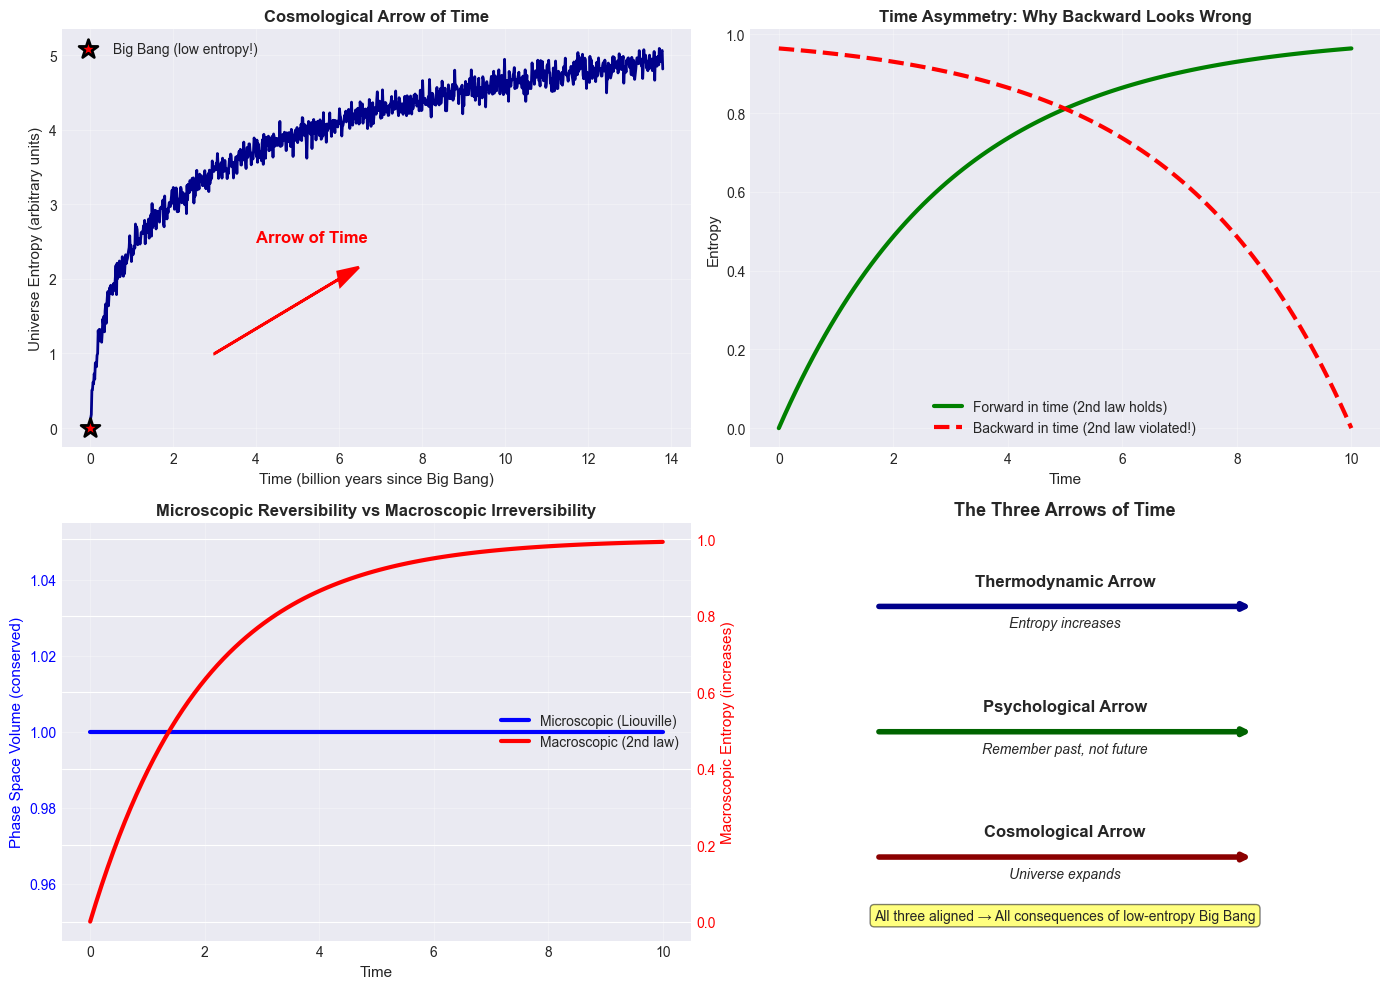


🔑 关于时间的深刻洞察：

1. 微观定律：时间可逆（牛顿力学、量子力学）
   → 反向运行定律在数学上是有效的

2. 宏观行为：时间不可逆（热力学）
   → 熵增加，混合发生，无法取消混合

3. 解决方案：初始条件 + 统计
   → 大爆炸具有极低的熵
   → 统计演化探索高熵状态
   → 粗粒化使演化看起来不可逆

4. 深层谜题：为什么大爆炸是低熵的？
   → 我们不知道！这是时间箭头的起源。
   → 一些理论：人择原理、弹跳宇宙学等。

5. 三个箭头，一个原因：
   → 热力学：熵 ↑（初始条件的后果）
   → 心理学：记忆向后工作（需要低熵）
   → 宇宙学：宇宙膨胀（与初始条件相关）

✓ 时间箭头分析完成！


In [9]:
# Visualize the arrow of time

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Entropy vs time for universe
ax = axes[0, 0]
time_universe = np.linspace(0, 13.8, 1000)  # Billion years
# Simplified model: entropy grows logarithmically with time
entropy_universe = np.log(1 + time_universe * 10) + np.random.randn(1000) * 0.1

ax.plot(time_universe, entropy_universe, linewidth=2, color='darkblue')
ax.scatter([0], [entropy_universe[0]], s=200, c='red', marker='*', 
          label='Big Bang (low entropy!)', zorder=5, edgecolor='black', linewidth=2)
ax.arrow(3, 1, 3, 1, head_width=0.2, head_length=0.5, fc='red', ec='red', linewidth=2)
ax.text(4, 2.5, 'Arrow of Time', fontsize=12, color='red', fontweight='bold')
ax.set_xlabel('Time (billion years since Big Bang)', fontsize=11)
ax.set_ylabel('Universe Entropy (arbitrary units)', fontsize=11)
ax.set_title('Cosmological Arrow of Time', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Forward vs backward in time
ax = axes[0, 1]
t = np.linspace(0, 10, 100)
entropy_forward = 1 - np.exp(-t/3)  # Entropy increases
entropy_backward = np.flip(entropy_forward)  # Time-reversed (entropy decreases)

ax.plot(t, entropy_forward, linewidth=3, color='green', label='Forward in time (2nd law holds)')
ax.plot(t, entropy_backward, linewidth=3, color='red', linestyle='--', 
       label='Backward in time (2nd law violated!)')
ax.set_xlabel('Time', fontsize=11)
ax.set_ylabel('Entropy', fontsize=11)
ax.set_title('Time Asymmetry: Why Backward Looks Wrong', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Phase space volume (Liouville) vs coarse-grained entropy
ax = axes[1, 0]
t = np.linspace(0, 10, 100)
phase_space_volume = np.ones_like(t)  # Constant (Liouville)
macro_entropy = 1 - np.exp(-t/2)  # Increases

ax2 = ax.twinx()
ax.plot(t, phase_space_volume, linewidth=3, color='blue', label='Microscopic (Liouville)')
ax2.plot(t, macro_entropy, linewidth=3, color='red', label='Macroscopic (2nd law)')
ax.set_xlabel('Time', fontsize=11)
ax.set_ylabel('Phase Space Volume (conserved)', fontsize=11, color='blue')
ax2.set_ylabel('Macroscopic Entropy (increases)', fontsize=11, color='red')
ax.set_title('Microscopic Reversibility vs Macroscopic Irreversibility', 
            fontsize=12, fontweight='bold')
ax.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='red')
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='center right')
ax.grid(True, alpha=0.3)

# Plot 4: Three arrows of time
ax = axes[1, 1]
ax.axis('off')

# Draw three arrows
arrow_props = dict(arrowstyle='->', lw=4, color='darkblue')
ax.annotate('', xy=(0.8, 0.8), xytext=(0.2, 0.8), arrowprops=arrow_props)
ax.text(0.5, 0.85, 'Thermodynamic Arrow', ha='center', fontsize=12, fontweight='bold')
ax.text(0.5, 0.75, 'Entropy increases', ha='center', fontsize=10, style='italic')

arrow_props['color'] = 'darkgreen'
ax.annotate('', xy=(0.8, 0.5), xytext=(0.2, 0.5), arrowprops=arrow_props)
ax.text(0.5, 0.55, 'Psychological Arrow', ha='center', fontsize=12, fontweight='bold')
ax.text(0.5, 0.45, 'Remember past, not future', ha='center', fontsize=10, style='italic')

arrow_props['color'] = 'darkred'
ax.annotate('', xy=(0.8, 0.2), xytext=(0.2, 0.2), arrowprops=arrow_props)
ax.text(0.5, 0.25, 'Cosmological Arrow', ha='center', fontsize=12, fontweight='bold')
ax.text(0.5, 0.15, 'Universe expands', ha='center', fontsize=10, style='italic')

ax.text(0.5, 0.05, 'All three aligned → All consequences of low-entropy Big Bang', 
       ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_title('The Three Arrows of Time', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n🔑 关于时间的深刻洞察：")
print("\n1. 微观定律：时间可逆（牛顿力学、量子力学）")
print("   → 反向运行定律在数学上是有效的")
print("\n2. 宏观行为：时间不可逆（热力学）")
print("   → 熵增加，混合发生，无法取消混合")
print("\n3. 解决方案：初始条件 + 统计")
print("   → 大爆炸具有极低的熵")
print("   → 统计演化探索高熵状态")
print("   → 粗粒化使演化看起来不可逆")
print("\n4. 深层谜题：为什么大爆炸是低熵的？")
print("   → 我们不知道！这是时间箭头的起源。")
print("   → 一些理论：人择原理、弹跳宇宙学等。")
print("\n5. 三个箭头，一个原因：")
print("   → 热力学：熵 ↑（初始条件的后果）")
print("   → 心理学：记忆向后工作（需要低熵）")
print("   → 宇宙学：宇宙膨胀（与初始条件相关）")
print("\n✓ 时间箭头分析完成！")

# 第9节：生物不可逆性 - 生命与第二定律

**生命违反第二定律吗？**

不！生命是一个**开放系统**，它：
1. 局部减少熵（创建秩序）
2. 整体增加熵（输出无序）

## 薛定谔的洞察

在"生命是什么？"（1944）中，薛定谔说：
> "生命以负熵为食"

生物体：
- 输入**低熵**能量（食物、阳光）
- 使用它维持秩序（新陈代谢、生长、繁殖）
- 输出**高熵**废物（热量、CO₂）

**净结果**：宇宙熵增加，第二定律得到满足

## 开放系统的第二定律

对于与环境交换熵 $S_{\text{env}}$ 的开放系统：

$$\frac{dS_{\text{system}}}{dt} + \frac{dS_{\text{env}}}{dt} \geq 0$$

$S_{\text{system}}$ 可以减少，如果 $S_{\text{env}}$ 增加更多！

让我们建模一下！

模拟开放系统（类似生命）与封闭系统...



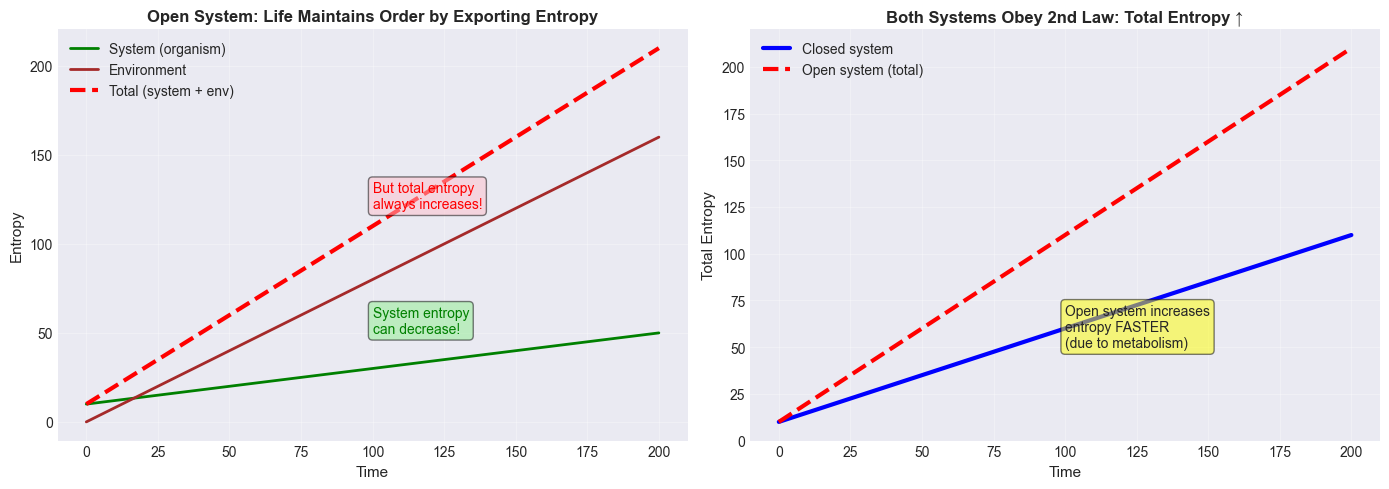


🔑 关于生命和熵的关键洞察：

1. 局部 vs 全局：
   → 系统熵: 10.0 → 50.0 (保持低！)
   → 总熵:   10.0 → 210.0 (增加了！)

2. 生命的技巧：
   → 导入低熵能量（食物、阳光）
   → 用它来构建秩序（蛋白质、细胞、生物体）
   → 导出高熵废物（热量、CO₂ 等）

3. 净结果：
   → 生物体熵 ↓（更多秩序）
   → 环境熵 ↑↑（更多无序）
   → 总熵 ↑（第二定律满足！）

4. 为什么有效：
   → 导出熵是不可逆的
   → 热量不能自发地重新集中
   → 这就是为什么死亡是不可避免的（最终无法导出足够的熵）

5. 薛定谔是对的：
   → 生命以负熵为食（秩序）
   → 导出正熵（无序）
   → 这就是生命如何与第二定律相容！

✓ 生物不可逆性演示完成！


In [10]:
# Model a simple "living" system that maintains order

def simulate_open_system(num_steps: int = 200) -> dict:
    """Simulate an open system that maintains low entropy.
    
    Returns:
        Dictionary with entropy histories
    """
    # Initialize
    S_system = 10.0  # System starts with moderate entropy
    S_environment = 0.0  # Track cumulative entropy exported
    
    S_system_history = [S_system]
    S_environment_history = [S_environment]
    S_total_history = [S_system + S_environment]
    
    for t in range(num_steps):
        # System processes: would naturally increase entropy
        natural_increase = 0.5
        
        # Active maintenance: system exports entropy to environment
        # This "costs" more entropy in environment than saved in system
        entropy_exported = 0.8  # More than natural increase (2nd law!)
        entropy_reduced = 0.3  # System entropy reduction
        
        # Update
        S_system = S_system + natural_increase - entropy_reduced
        S_environment = S_environment + entropy_exported
        
        # Record
        S_system_history.append(S_system)
        S_environment_history.append(S_environment)
        S_total_history.append(S_system + S_environment)
    
    return {
        'system': S_system_history,
        'environment': S_environment_history,
        'total': S_total_history
    }


def simulate_closed_system(num_steps: int = 200) -> dict:
    """Simulate a closed system (for comparison)."""
    S_total = 10.0
    S_total_history = [S_total]
    
    for t in range(num_steps):
        # Entropy only increases in closed system
        S_total = S_total + 0.5
        S_total_history.append(S_total)
    
    return {'total': S_total_history}


print("模拟开放系统（类似生命）与封闭系统...\n")

open_sys = simulate_open_system()
closed_sys = simulate_closed_system()

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Open system (life)
ax = axes[0]
t = np.arange(len(open_sys['total']))
ax.plot(t, open_sys['system'], linewidth=2, label='System (organism)', color='green')
ax.plot(t, open_sys['environment'], linewidth=2, label='Environment', color='brown')
ax.plot(t, open_sys['total'], linewidth=3, label='Total (system + env)', 
       color='red', linestyle='--')
ax.set_xlabel('Time', fontsize=11)
ax.set_ylabel('Entropy', fontsize=11)
ax.set_title('Open System: Life Maintains Order by Exporting Entropy', 
            fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.text(100, 50, 'System entropy\ncan decrease!', fontsize=10, color='green',
       bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
ax.text(100, 120, 'But total entropy\nalways increases!', fontsize=10, color='red',
       bbox=dict(boxstyle='round', facecolor='pink', alpha=0.5))

# Plot 2: Comparison with closed system
ax = axes[1]
ax.plot(t, closed_sys['total'], linewidth=3, label='Closed system', color='blue')
ax.plot(t, open_sys['total'], linewidth=3, label='Open system (total)', 
       color='red', linestyle='--')
ax.set_xlabel('Time', fontsize=11)
ax.set_ylabel('Total Entropy', fontsize=11)
ax.set_title('Both Systems Obey 2nd Law: Total Entropy ↑', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.text(100, 50, 'Open system increases\nentropy FASTER\n(due to metabolism)', 
       fontsize=10, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

plt.tight_layout()
plt.show()

print("\n🔑 关于生命和熵的关键洞察：")
print("\n1. 局部 vs 全局：")
print(f"   → 系统熵: {open_sys['system'][0]:.1f} → {open_sys['system'][-1]:.1f} (保持低！)")
print(f"   → 总熵:   {open_sys['total'][0]:.1f} → {open_sys['total'][-1]:.1f} (增加了！)")
print("\n2. 生命的技巧：")
print("   → 导入低熵能量（食物、阳光）")
print("   → 用它来构建秩序（蛋白质、细胞、生物体）")
print("   → 导出高熵废物（热量、CO₂ 等）")
print("\n3. 净结果：")
print("   → 生物体熵 ↓（更多秩序）")
print("   → 环境熵 ↑↑（更多无序）")
print("   → 总熵 ↑（第二定律满足！）")
print("\n4. 为什么有效：")
print("   → 导出熵是不可逆的")
print("   → 热量不能自发地重新集中")
print("   → 这就是为什么死亡是不可避免的（最终无法导出足够的熵）")
print("\n5. 薛定谔是对的：")
print("   → 生命以负熵为食（秩序）")
print("   → 导出正熵（无序）")
print("   → 这就是生命如何与第二定律相容！")
print("\n✓ 生物不可逆性演示完成！")

# 第10节：综合 - 各尺度的不可逆性

我们已经从咖啡杯到宇宙探讨了不可逆性。让我们综合一下。

## 不可逆性的层次

| 尺度 | 系统 | 可逆？ | 为什么不可逆？ |
|-------|--------|-------------|-------------------|
| **微观** | 单个粒子 | ✅ 是 | 牛顿/量子定律是时间对称的 |
| **介观** | 小群体（~100s） | ⚠️ 实际不 | 庞加莱回归时间 >> 观察时间 |
| **宏观** | 日常物体 | ❌ 否 | 粗粒化 + 统计学 + 高 N |
| **宇宙学** | 宇宙 | ❌ 否 | 低熵初始条件 |

## 共同主线

所有形式的不可逆性都分享：

1. **粗粒化**：丢失细粒度信息
   - 物理学：宏观态 vs 微观态
   - 计算：哈希函数，有损压缩
   - ML：神经网络瓶颈

2. **多对一映射**：多个输入 → 相同输出
   - 咖啡：许多分子配置 → 相同宏观外观
   - 哈希：许多字符串 → 相同哈希值
   - 神经网络：许多图像 → 相同类别

3. **信息丢失**：无法恢复原始状态
   - 热力学：熵增加
   - 兰道尔：位擦除成本能量
   - ML：压缩丢弃细节

4. **统计偏差**：向高概率状态演化
   - 物理学：平衡态最可能
   - 计算：状态空间中的随机游走
   - ML：梯度下降趋向极小值

## 深刻含义

### 对于物理学
- 时间是涌现的，不是基本的
- 第二定律是统计的，不是绝对的
- 低熵初始条件是关键谜题

### 对于计算
- 所有计算都有热力学成本
- 可逆计算可能"免费"
- 信息是物理的（不是抽象的）

### 对于机器学习
- 压缩是本质的（用于泛化）
- 信息瓶颈 = 好的归纳偏差
- 遗忘（不可逆）有助于学习

### 对于生命
- 开放系统可以维持秩序
- 但必须输出熵
- 死亡是热力学必然性

## 终极问题

**为什么宇宙诞生时熵如此低？**

这单一事实解释了：
- 时间箭头
- 为什么混合是不可逆的
- 为什么我们记住过去，不记住未来
- 为什么生命可能存在
- 为什么计算是可能的

我们不知道答案。但这是物理学中最深的问题之一。

---

## 与机器学习的联系（重新审视）

**为什么这对 AI 很重要？**

1. **信息瓶颈**：神经网络必须压缩 → 不可逆
2. **单向函数**：安全性取决于计算不可逆性
3. **兰道尔限制**：未来 AI 能效受热力学限制
4. **记忆**：大脑/计算机必须擦除旧记忆 → 熵成本
5. **学习 = 压缩**：好的模型压缩数据不可逆地

**不可逆性不是 bug——它是特性！**

没有它：
- 没有泛化（会记住一切）
- 没有计算（没有单向函数）
- 没有安全性（可以逆转任何函数）
- 没有学习（没有抽象）

**你不能取消咖啡的混合。但如果你能，你无法思考它。**

/Users/guchen/repo_own/sutskever-30-implementations-zhCN/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9749 (\N{HOT BEVERAGE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


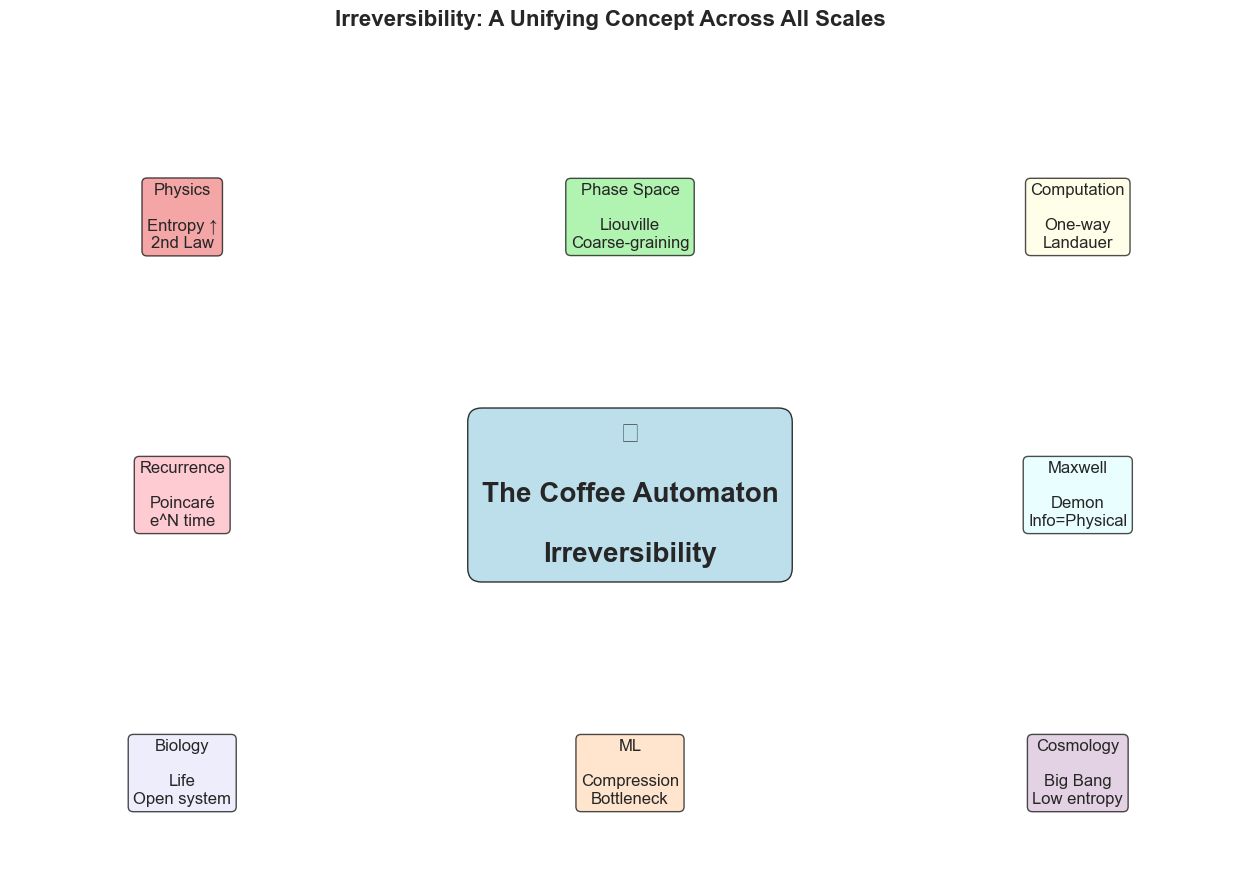


总结：咖啡自动机 - 关键要点

1. 基本谜题：
   • 微观定律是可逆的（牛顿、薛定谔）
   • 宏观行为是不可逆的（咖啡混合，永不取消混合）
   • 解决方案：粗粒化 + 统计 + 低熵初始条件

2. 不可逆性的机制：
   • 粗粒化：在分组微观态时丢失信息
   • 统计力学：高熵态远多于低熵态
   • 庞加莱回归：可逆，但时间尺度 e^N >> 宇宙年龄

3. 信息是物理的：
   • 兰道尔原理：擦除 1 位成本 k_B T ln(2) 能量
   • 麦克斯韦妖：信息收集/擦除有熵成本
   • 计算：所有不可逆操作都散发热量

4. 计算不可逆性：
   • 单向函数：向前容易，向后困难
   • 加密哈希：多个输入 → 相同输出
   • 安全性依赖于计算不可逆性

5. 机器学习：
   • 神经网络压缩（信息瓶颈）
   • 压缩 = 不可逆 = 遗忘细节
   • 泛化需要不可逆性！

6. 生命与热力学：
   • 生命是开放系统：导入秩序，导出无序
   • 局部熵 ↓，但总熵 ↑（第二定律满足）
   • 死亡是热力学必然性

7. 时间箭头：
   • 不在定律中——在初始条件中！
   • 大爆炸具有极低的熵（为什么？？）
   • 所有三个箭头（热力学、心理学、宇宙学）对齐

8. 深层谜题：
   • 为什么大爆炸是低熵的？
   • 这一个事实解释了时间箭头
   • 仍未解决！物理学中最深的问题之一


☕ 咖啡自动机：简单系统，深刻含义

你无法取消咖啡的混合。
但这种不可逆性正是使计算、生命和思想成为可能的原因。


✓ 不可逆性的完整分析完成！

🎓 论文 19 实现完成：深入探讨咖啡自动机。


In [11]:
# Final visualization: The complete picture

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Central concept: The arrow of time
ax_center = fig.add_subplot(gs[1, 1])
ax_center.axis('off')
ax_center.text(0.5, 0.5, '☕\n\nThe Coffee Automaton\n\nIrreversibility', 
              ha='center', va='center', fontsize=20, fontweight='bold',
              bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8))
ax_center.set_xlim(0, 1)
ax_center.set_ylim(0, 1)

# Surrounding concepts
concepts = [
    ("Physics\n\nEntropy ↑\n2nd Law", gs[0, 0]),
    ("Phase Space\n\nLiouville\nCoarse-graining", gs[0, 1]),
    ("Computation\n\nOne-way\nLandauer", gs[0, 2]),
    ("Recurrence\n\nPoincaré\ne^N time", gs[1, 0]),
    ("Maxwell\n\nDemon\nInfo=Physical", gs[1, 2]),
    ("Biology\n\nLife\nOpen system", gs[2, 0]),
    ("ML\n\nCompression\nBottleneck", gs[2, 1]),
    ("Cosmology\n\nBig Bang\nLow entropy", gs[2, 2]),
]

colors = ['lightcoral', 'lightgreen', 'lightyellow', 'lightpink', 
         'lightcyan', 'lavender', 'peachpuff', 'thistle']

for (text, pos), color in zip(concepts, colors):
    ax = fig.add_subplot(pos)
    ax.axis('off')
    ax.text(0.5, 0.5, text, ha='center', va='center', fontsize=12,
           bbox=dict(boxstyle='round', facecolor=color, alpha=0.7))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    
    # Draw arrow to center
    ax.annotate('', xy=(0.5, 0.5), xytext=(0.5, 0.5),
               arrowprops=dict(arrowstyle='->', lw=2, color='gray', alpha=0.5))

plt.suptitle('Irreversibility: A Unifying Concept Across All Scales', 
            fontsize=16, fontweight='bold', y=0.98)
plt.show()

# Summary statistics
print("\n" + "="*70)
print("总结：咖啡自动机 - 关键要点")
print("="*70)

print("\n1. 基本谜题：")
print("   • 微观定律是可逆的（牛顿、薛定谔）")
print("   • 宏观行为是不可逆的（咖啡混合，永不取消混合）")
print("   • 解决方案：粗粒化 + 统计 + 低熵初始条件")

print("\n2. 不可逆性的机制：")
print("   • 粗粒化：在分组微观态时丢失信息")
print("   • 统计力学：高熵态远多于低熵态")
print("   • 庞加莱回归：可逆，但时间尺度 e^N >> 宇宙年龄")

print("\n3. 信息是物理的：")
print("   • 兰道尔原理：擦除 1 位成本 k_B T ln(2) 能量")
print("   • 麦克斯韦妖：信息收集/擦除有熵成本")
print("   • 计算：所有不可逆操作都散发热量")

print("\n4. 计算不可逆性：")
print("   • 单向函数：向前容易，向后困难")
print("   • 加密哈希：多个输入 → 相同输出")
print("   • 安全性依赖于计算不可逆性")

print("\n5. 机器学习：")
print("   • 神经网络压缩（信息瓶颈）")
print("   • 压缩 = 不可逆 = 遗忘细节")
print("   • 泛化需要不可逆性！")

print("\n6. 生命与热力学：")
print("   • 生命是开放系统：导入秩序，导出无序")
print("   • 局部熵 ↓，但总熵 ↑（第二定律满足）")
print("   • 死亡是热力学必然性")

print("\n7. 时间箭头：")
print("   • 不在定律中——在初始条件中！")
print("   • 大爆炸具有极低的熵（为什么？？）")
print("   • 所有三个箭头（热力学、心理学、宇宙学）对齐")

print("\n8. 深层谜题：")
print("   • 为什么大爆炸是低熵的？")
print("   • 这一个事实解释了时间箭头")
print("   • 仍未解决！物理学中最深的问题之一")

print("\n" + "="*70)
print("\n☕ 咖啡自动机：简单系统，深刻含义")
print("\n你无法取消咖啡的混合。")
print("但这种不可逆性正是使计算、生命和思想成为可能的原因。")
print("\n" + "="*70)
print("\n✓ 不可逆性的完整分析完成！")
print("\n🎓 论文 19 实现完成：深入探讨咖啡自动机。")